# Import and misc

In [1]:
!pip install torchaudio==0.9.1

     |████████████████████████████████| 1.9 MB 12.2 MB/s 
     |████████████████████████████████| 831.4 MB 6.9 kB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchvision 0.11.1+cu111 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.
torchtext 0.11.0 requires torch==1.10.0, but you have torch 1.9.1 which is incompatible.


In [2]:
from typing import Tuple, Union, List, Callable, Optional
from tqdm import tqdm
from itertools import islice
import pathlib
import dataclasses

import numpy as np
import pandas as pd

import torch
import torch.nn.functional as F
from torch import nn
from torch import distributions
from torch.utils.data import DataLoader, Dataset, WeightedRandomSampler
from torch.nn.utils.rnn import pad_sequence

import torchaudio
from IPython import display as display_
import random

# Task

In this notebook we will implement a model for finding a keyword in a stream.

We will implement the version with CRNN because it is easy and improves the model. 
(from https://www.dropbox.com/s/22ah2ba7dug6pzw/KWS_Attention.pdf)

In [3]:
@dataclasses.dataclass
class TaskConfig:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 3e-4
    weight_decay: float = 1e-5
    num_epochs: int = 20
    n_mels: int = 40
    cnn_out_channels: int = 8
    kernel_size: Tuple[int, int] = (5, 20)
    stride: Tuple[int, int] = (2, 8)
    hidden_size: int = 64
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

# Data

In [4]:
!wget http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz -O speech_commands_v0.01.tar.gz
!mkdir speech_commands && tar -C speech_commands -xvzf speech_commands_v0.01.tar.gz 1> log

--2021-11-22 11:23:14--  http://download.tensorflow.org/data/speech_commands_v0.01.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 74.125.140.128, 2a00:1450:400c:c08::80
Connecting to download.tensorflow.org (download.tensorflow.org)|74.125.140.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1489096277 (1.4G) [application/gzip]
Saving to: ‘speech_commands_v0.01.tar.gz’

speech_commands_v0. 100%[===================>]   1.39G  96.6MB/s    in 21s     

2021-11-22 11:23:35 (67.4 MB/s) - ‘speech_commands_v0.01.tar.gz’ saved [1489096277/1489096277]



In [5]:
class SpeechCommandDataset(Dataset):

    def __init__(
        self,
        transform: Optional[Callable] = None,
        path2dir: str = None,
        keywords: Union[str, List[str]] = None,
        csv: Optional[pd.DataFrame] = None
    ):        
        self.transform = transform

        if csv is None:
            path2dir = pathlib.Path(path2dir)
            keywords = keywords if isinstance(keywords, list) else [keywords]
            
            all_keywords = [
                p.stem for p in path2dir.glob('*')
                if p.is_dir() and not p.stem.startswith('_')
            ]

            triplets = []
            for keyword in all_keywords:
                paths = (path2dir / keyword).rglob('*.wav')
                if keyword in keywords:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 1))
                else:
                    for path2wav in paths:
                        triplets.append((path2wav.as_posix(), keyword, 0))
            
            self.csv = pd.DataFrame(
                triplets,
                columns=['path', 'keyword', 'label']
            )

        else:
            self.csv = csv
    
    def __getitem__(self, index: int):
        instance = self.csv.iloc[index]

        path2wav = instance['path']
        wav, sr = torchaudio.load(path2wav)
        wav = wav.sum(dim=0)
        
        if self.transform:
            wav = self.transform(wav)

        return {
            'wav': wav,
            'keywors': instance['keyword'],
            'label': instance['label']
        }

    def __len__(self):
        return len(self.csv)

In [6]:
dataset = SpeechCommandDataset(
    path2dir='speech_commands', keywords=TaskConfig.keyword
)

In [7]:
dataset.csv

,path,keyword,label
0,speech_commands/no/10ace7eb_nohash_1.wav,no,0
1,speech_commands/no/964e8cfd_nohash_3.wav,no,0
2,speech_commands/no/8e05039f_nohash_2.wav,no,0
3,speech_commands/no/439c84f4_nohash_2.wav,no,0
4,speech_commands/no/6b7d5101_nohash_0.wav,no,0
...,...,...,...
64716,speech_commands/three/f9273a21_nohash_4.wav,three,0
64717,speech_commands/three/8830e17f_nohash_4.wav,three,0
64718,speech_commands/three/ec7d1151_nohash_0.wav,three,0
64719,speech_commands/three/b00dff7e_nohash_2.wav,three,0


### Augmentations

In [8]:
class AugsCreation:

    def __init__(self):
        self.background_noises = [
            'speech_commands/_background_noise_/white_noise.wav',
            'speech_commands/_background_noise_/dude_miaowing.wav',
            'speech_commands/_background_noise_/doing_the_dishes.wav',
            'speech_commands/_background_noise_/exercise_bike.wav',
            'speech_commands/_background_noise_/pink_noise.wav',
            'speech_commands/_background_noise_/running_tap.wav'
        ]

        self.noises = [
            torchaudio.load(p)[0].squeeze()
            for p in self.background_noises
        ]

    def add_rand_noise(self, audio):

        # randomly choose noise
        noise_num = torch.randint(low=0, high=len(
            self.background_noises), size=(1,)).item()
        noise = self.noises[noise_num]

        noise_level = torch.Tensor([1])  # [0, 40]

        noise_energy = torch.norm(noise)
        audio_energy = torch.norm(audio)
        alpha = (audio_energy / noise_energy) * \
            torch.pow(10, -noise_level / 20)

        start = torch.randint(
            low=0,
            high=max(int(noise.size(0) - audio.size(0) - 1), 1),
            size=(1,)
        ).item()
        noise_sample = noise[start: start + audio.size(0)]

        audio_new = audio + alpha * noise_sample
        audio_new.clamp_(-1, 1)
        return audio_new

    def __call__(self, wav):
        aug_num = torch.randint(low=0, high=4, size=(1,)).item()   # choose 1 random aug from augs
        augs = [
            lambda x: x,
            lambda x: (x + distributions.Normal(0, 0.01).sample(x.size())).clamp_(-1, 1),
            lambda x: torchaudio.transforms.Vol(.25)(x),
            lambda x: self.add_rand_noise(x)
        ]

        return augs[aug_num](wav)

In [9]:
torch.manual_seed(0)
indexes = torch.randperm(len(dataset))
train_indexes = indexes[:int(len(dataset) * 0.8)]
val_indexes = indexes[int(len(dataset) * 0.8):]

train_df = dataset.csv.iloc[train_indexes].reset_index(drop=True)
val_df = dataset.csv.iloc[val_indexes].reset_index(drop=True)

In [10]:
print(indexes)

tensor([61945, 34000, 21757,  ..., 32671, 32669, 10036])


In [11]:
# Sample is a dict of utt, word and label
train_set = SpeechCommandDataset(csv=train_df, transform=AugsCreation())
val_set = SpeechCommandDataset(csv=val_df)

### Sampler for oversampling:

In [12]:
# We should provide to WeightedRandomSampler _weight for every sample_; by default it is 1/len(target)

def get_sampler(target):
    class_sample_count = np.array(
        [len(np.where(target == t)[0]) for t in np.unique(target)])   # for every class count it's number of occ.
    weight = 1. / class_sample_count
    samples_weight = np.array([weight[t] for t in target])
    samples_weight = torch.from_numpy(samples_weight)
    samples_weigth = samples_weight.float()
    sampler = WeightedRandomSampler(samples_weight, len(samples_weight))
    return sampler

In [13]:
train_sampler = get_sampler(train_set.csv['label'].values)

In [14]:
class Collator:
    
    def __call__(self, data):
        wavs = []
        labels = []    

        for el in data:
            wavs.append(el['wav'])
            labels.append(el['label'])

        # torch.nn.utils.rnn.pad_sequence takes list(Tensors) and returns padded (with 0.0) Tensor
        wavs = pad_sequence(wavs, batch_first=True)    
        labels = torch.Tensor(labels).long()
        return wavs, labels

###  Dataloaders

In [15]:
# Here we are obliged to use shuffle=False because of our sampler with randomness inside.

train_loader = DataLoader(train_set, batch_size=TaskConfig.batch_size,
                          shuffle=False, collate_fn=Collator(),
                          sampler=train_sampler,
                          num_workers=2, pin_memory=True)

val_loader = DataLoader(val_set, batch_size=TaskConfig.batch_size,
                        shuffle=False, collate_fn=Collator(),
                        num_workers=2, pin_memory=True)

### Creating MelSpecs on GPU for speeeed: 

In [16]:
class LogMelspec:

    def __init__(self, is_train, config):
        # with augmentations
        if is_train:
            self.melspec = nn.Sequential(
                torchaudio.transforms.MelSpectrogram(
                    sample_rate=config.sample_rate,
                    n_fft=400,
                    win_length=400,
                    hop_length=160,
                    n_mels=config.n_mels
                ),
                torchaudio.transforms.FrequencyMasking(freq_mask_param=15),
                torchaudio.transforms.TimeMasking(time_mask_param=35),
            ).to(config.device)

        # no augmentations
        else:
            self.melspec = torchaudio.transforms.MelSpectrogram(
                sample_rate=config.sample_rate,
                n_fft=400,
                win_length=400,
                hop_length=160,
                n_mels=config.n_mels
            ).to(config.device)

    def __call__(self, batch):
        # already on device
        return torch.log(self.melspec(batch).clamp_(min=1e-9, max=1e9))

In [17]:
melspec_train = LogMelspec(is_train=True, config=TaskConfig)
melspec_val = LogMelspec(is_train=False, config=TaskConfig)

### Quality measurment functions:

In [18]:
# FA - true: 0, model: 1
# FR - true: 1, model: 0

def count_FA_FR(preds, labels):
    FA = torch.sum(preds[labels == 0])
    FR = torch.sum(labels[preds == 0])
    
    # torch.numel - returns total number of elements in tensor
    return FA.item() / torch.numel(preds), FR.item() / torch.numel(preds)

In [19]:
def get_au_fa_fr(probs, labels):
    sorted_probs, _ = torch.sort(probs)
    sorted_probs = torch.cat((torch.Tensor([0]), sorted_probs, torch.Tensor([1])))
    labels = torch.cat(labels, dim=0)
        
    FAs, FRs = [], []
    for prob in sorted_probs:
        preds = (probs >= prob) * 1
        FA, FR = count_FA_FR(preds, labels)        
        FAs.append(FA)
        FRs.append(FR)
    # plt.plot(FAs, FRs)
    # plt.show()

    # ~ area under curve using trapezoidal rule
    return -np.trapz(FRs, x=FAs)

# Model

In [24]:
class Attention(nn.Module):

    def __init__(self, hidden_size: int):
        super().__init__()

        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input):
        energy = self.energy(input)
        alpha = torch.softmax(energy, dim=-2)
        return (input * alpha).sum(dim=-2)

class CRNN(nn.Module):

    def __init__(self, config: TaskConfig):
        super().__init__()
        self.config = config

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention(config.hidden_size)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)
    
    def forward(self, input):
        input = input.unsqueeze(dim=1)
        conv_output = self.conv(input).transpose(-1, -2)
        gru_output, _ = self.gru(conv_output)
        contex_vector = self.attention(gru_output)
        output = self.classifier(contex_vector)
        return output

config = TaskConfig()
model = CRNN(config)
model

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)

In [25]:
def train_epoch(model, opt, loader, log_melspec, device):
    model.train()
    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        opt.zero_grad()

        # run model # with autocast():
        logits = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(logits, dim=-1)
        loss = F.cross_entropy(logits, labels)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 5)

        opt.step()

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)

    return acc

In [26]:
@torch.no_grad()
def validation(model, loader, log_melspec, device):
    model.eval()

    val_losses, accs, FAs, FRs = [], [], [], []
    all_probs, all_labels = [], []
    for i, (batch, labels) in tqdm(enumerate(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)

        output = model(batch)
        # we need probabilities so we use softmax & CE separately
        probs = F.softmax(output, dim=-1)
        loss = F.cross_entropy(output, labels)

        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        all_probs.append(probs[:, 1].cpu())
        all_labels.append(labels.cpu())
        val_losses.append(loss.item())
        accs.append(
            torch.sum(argmax_probs == labels).item() /  # ???
            torch.numel(argmax_probs)
        )
        FA, FR = count_FA_FR(argmax_probs, labels)
        FAs.append(FA)
        FRs.append(FR)

    # area under FA/FR curve for whole loader
    au_fa_fr = get_au_fa_fr(torch.cat(all_probs, dim=0).cpu(), all_labels)
    return au_fa_fr

In [27]:
from collections import defaultdict
from IPython.display import clear_output
from matplotlib import pyplot as plt

history = defaultdict(list)

# Training

In [ ]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [ ]:
sum([p.numel() for p in model.parameters()])

70443

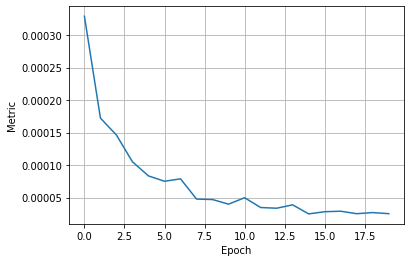

END OF EPOCH 19


In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
validation(model, val_loader, melspec_val, config.device)

102it [00:07, 14.05it/s]


2.515918060200918e-05

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.00032888348229078037,
              0.00017218165035810508,
              0.00014607362969069754,
              0.00010490948647611988,
              8.323535366148578e-05,
              7.501207309470006e-05,
              7.875372542806337e-05,
              4.759715950702686e-05,
              4.690492398761674e-05,
              3.9797574818500767e-05,
              4.9709671350743946e-05,
              3.462371106566824e-05,
              3.35435849534852e-05,
              3.872938380147998e-05,
              2.4783225104398517e-05,
              2.8172792130475655e-05,
              2.8930670673278113e-05,
              2.511144022136021e-05,
              2.6836061472304388e-05,
              2.515918060200918e-05]})

### Reproduce

In [ ]:
history = defaultdict(list)
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


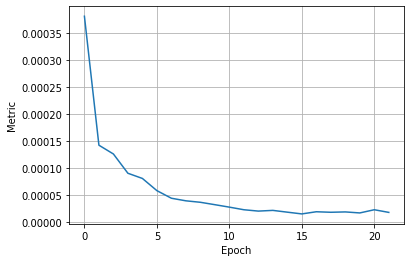

END OF EPOCH 1


 11%|█         | 43/405 [00:04<00:36,  9.78it/s]


KeyboardInterrupt: ignored

In [ ]:
# TRAIN

for n in range(TaskConfig.num_epochs):

    train_epoch(model, opt, train_loader,
                melspec_train, config.device)

    au_fa_fr = validation(model, val_loader,
                          melspec_val, config.device)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list, {})

# Save model

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# PATH_base = '/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/base_model.pt'

In [ ]:
# torch.save(model.state_dict(),PATH_) 

# Load model

In [28]:
config = TaskConfig()
model = CRNN(config).to(config.device)

print(model)

opt = torch.optim.Adam(
    model.parameters(),
    lr=config.learning_rate,
    weight_decay=config.weight_decay
)

CRNN(
  (conv): Sequential(
    (0): Conv2d(1, 8, kernel_size=(5, 20), stride=(2, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(144, 64, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention(
    (energy): Sequential(
      (0): Linear(in_features=64, out_features=64, bias=True)
      (1): Tanh()
      (2): Linear(in_features=64, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=64, out_features=2, bias=True)
)


In [29]:
!gdown --id  1-5qMh3iJAC6TVIl9GOWbdmhX91l4AmsC

Downloading...
From: https://drive.google.com/uc?id=1-5qMh3iJAC6TVIl9GOWbdmhX91l4AmsC
To: /content/base_model.pt
100% 285k/285k [00:00<00:00, 45.6MB/s]


In [30]:
PATH_base = '/content/base_model.pt'

In [31]:
model = CRNN(config).to(config.device)
checkpoint = torch.load(PATH_base)

In [32]:
model.load_state_dict(checkpoint)

<All keys matched successfully>

In [33]:
validation(model, val_loader, melspec_val, config.device)

102it [00:07, 14.09it/s]


2.515918060200918e-05

In [34]:
!pip install thop

In [35]:
from thop import profile  # !pip install thop

In [36]:
input = torch.randn(1, 40, 100).to(config.device)

In [37]:
profile(model, inputs=(input.to("cuda:0"), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(933808.0, 70443.0)

# Streaming ⚓😞

### Streaming

In [ ]:
import IPython

In [ ]:
dataset.csv.loc(0)[1][0]

'speech_commands/no/964e8cfd_nohash_3.wav'

In [ ]:
dataset.csv.sample(20)

,path,keyword,label
63242,speech_commands/three/2151b09a_nohash_1.wav,three,0
52427,speech_commands/sheila/bbaa7946_nohash_0.wav,sheila,1
54976,speech_commands/go/3c6d55b3_nohash_1.wav,go,0
41517,speech_commands/eight/28ed6bc9_nohash_1.wav,eight,0
63573,speech_commands/three/e20be42a_nohash_0.wav,three,0
38169,speech_commands/zero/190821dc_nohash_2.wav,zero,0
25292,speech_commands/up/6c6aa323_nohash_0.wav,up,0
21806,speech_commands/seven/617de221_nohash_3.wav,seven,0
21361,speech_commands/seven/be7a5b2d_nohash_2.wav,seven,0
8134,speech_commands/yes/c25a032b_nohash_1.wav,yes,0


In [ ]:
num = 20836

In [ ]:
au , sr = torchaudio.load(dataset.csv.loc(0)[num][0])

In [ ]:
IPython.display.Audio(dataset.csv.loc(0)[num][0])

In [ ]:
sample = melspec_val(au.to(config.device))
output = model(sample)
# we need probabilities so we use softmax & CE separately
probs = F.softmax(output, dim=-1)
argmax_probs = torch.argmax(probs, dim=-1)
argmax_probs

tensor([0], device='cuda:0')

In [ ]:
sample.shape

torch.Size([1, 40, 101])

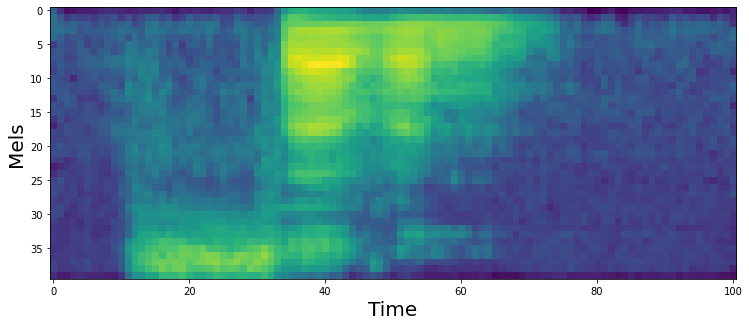

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(sample.to("cpu").squeeze())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

Choose 9 semples from dataset

In [ ]:
import random

In [ ]:
df = dataset.csv


In [ ]:
def mergeaudio(num = 5):
    other_words = df.loc[df['keyword'] != config.keyword]
    key_words = df.loc[df['keyword'] == config.keyword]
    not_key_words_aud = random.sample(list(other_words.index),num)
    key_word_audios = random.sample(list(key_words.index), 1)
    return not_key_words_aud, key_word_audios

def concratinate_wavs(others, key):
    audios = []
    for i, index in enumerate(others):
            au , sr = torchaudio.load(df.loc(0)[ index ][0])
            au = melspec_val(au.to(config.device))
            audios.append(au)
    au , sr = torchaudio.load(df.loc(0)[ key[0] ][0])
    au = melspec_val(au.to(config.device))
    audios.insert(len(audios) // 2, au)
    # print( torch.cat(audios,dim=1))
    concat = torch.cat(audios,dim=2)
    return concat
    

In [ ]:
oth, key = mergeaudio()
au = concratinate_wavs(oth, key)
oth, key

([21716, 36115, 6632, 7219, 4480], [52262])

In [ ]:
for i in au:
    print(i.shape)

torch.Size([40, 606])


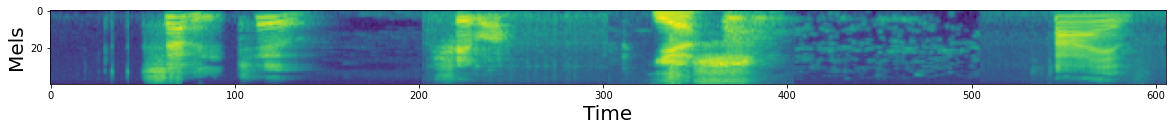

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(au.to("cpu").squeeze())
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
au.shape

torch.Size([1, 40, 606])

In [ ]:
output = model(au)
probs = F.softmax(output, dim=-1)
argmax_probs = torch.argmax(probs, dim=-1)
argmax_probs

tensor([1], device='cuda:0')

In [ ]:
def inference(spec):
    pass

In [ ]:
inference(au)

In [ ]:
au = au.squeeze()
ls_ind = []
ls_prob = []
with torch.no_grad():
    try:
        for i in range(0,au.shape[-1],20):
            
            loc = au.T[i: i + 20 ].T.unsqueeze(0)
            output = model(loc).to("cpu")
            # we need probabilities so we use softmax & CE separately
            probs = F.softmax(output, dim=-1)
            ls_ind.append(i)
            prob = probs[0][1].item()
            print(i,prob)
            ls_prob.append(prob)
    except:
        pass

0 0.22863070666790009
20 0.3348079323768616
40 0.31963270902633667
60 0.10039447993040085
80 0.7150769829750061
100 0.7882500886917114
120 0.6130371689796448
140 0.47420138120651245
160 0.36672884225845337
180 0.3681921064853668
200 0.2970823347568512
220 0.8916735649108887
240 0.3177793323993683
260 0.2771998345851898
280 0.30143898725509644
300 0.4390639066696167
320 0.5998627543449402
340 0.5841010212898254
360 0.49700018763542175
380 0.43216419219970703
400 0.6326748728752136
420 0.26547887921333313
440 0.303048312664032
460 0.3802952170372009
480 0.6642375588417053
500 0.39630797505378723
520 0.35201576352119446
540 0.46281126141548157
560 0.2456449717283249
580 0.4460029900074005


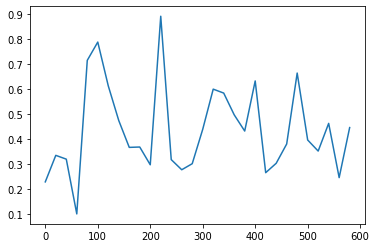

In [ ]:
plt.plot(ls_ind,ls_prob)

In [ ]:
au.shape

torch.Size([40, 606])

### INFERENCE

In [ ]:
def inference(spec):
    pass


In [ ]:
au = au.squeeze()
ls_ind = []
ls_prob = []
with torch.no_grad():
    try:
        for i in range(20,au.shape[-1],1):
            
            loc = au.T[i: i + 20 ].T.unsqueeze(0)
            output = model(loc).to("cpu")
            # we need probabilities so we use softmax & CE separately
            probs = F.softmax(output, dim=-1)
            ls_ind.append(i)
            prob = probs[0][1].item()
            print(i,prob)
            ls_prob.append(prob)
    except:
        pass

20 0.3348079323768616
21 0.29776641726493835
22 0.39414119720458984
23 0.3115648329257965
24 0.37720873951911926
25 0.5511002540588379
26 0.3892917037010193
27 0.4076358377933502
28 0.4272238314151764
29 0.4398089349269867
30 0.4488382339477539
31 0.2861967980861664
32 0.3300529718399048
33 0.2971334457397461
34 0.23448988795280457
35 0.3788934051990509
36 0.4233027696609497
37 0.41422173380851746
38 0.42734500765800476
39 0.4239541292190552
40 0.31963270902633667
41 0.30471929907798767
42 0.4172399938106537
43 0.40411177277565
44 0.4515460431575775
45 0.52427077293396
46 0.5907357931137085
47 0.7452226281166077
48 0.7468322515487671
49 0.7485541701316833
50 0.7748701572418213
51 0.8364247679710388
52 0.7697701454162598
53 0.57300865650177
54 0.49054208397865295
55 0.5462119579315186
56 0.5017467141151428
57 0.27057287096977234
58 0.13510781526565552
59 0.09328438341617584
60 0.10039447993040085
61 0.2871336340904236
62 0.3360309302806854
63 0.35870984196662903
64 0.35314327478408813
6

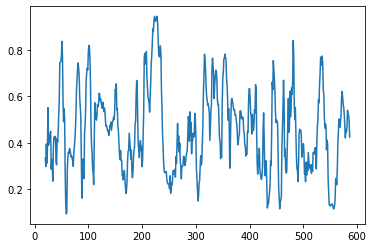

In [ ]:
plt.plot(ls_ind,ls_prob)

In [ ]:
ls_ind = []
ls_prob = []

max_window_length = 20
rep = au.T[: max_window_length]
with torch.no_grad():
    for i in range(max_window_length,au.shape[1],1):
        if i != max_window_length:
            rep = rep[1:]
            next_T_plus1 =  au.T[i]
            rep = torch.vstack((rep, next_T_plus1))
            output = model(rep.T.unsqueeze(0)).to("cpu")
            probs = F.softmax(output, dim=-1)
            prob = probs[0][1].item()
            print(i,prob)
            ls_ind.append(i)
            ls_prob.append(prob)
        else:
            continue
rep = rep.T

21 0.2483496516942978
22 0.23761624097824097
23 0.25861114263534546
24 0.2668212056159973
25 0.26307958364486694
26 0.2406395822763443
27 0.2686602473258972
28 0.2912900447845459
29 0.3367794454097748
30 0.29501873254776
31 0.2881895899772644
32 0.3613933026790619
33 0.5280641913414001
34 0.5804547071456909
35 0.5955087542533875
36 0.6605392694473267
37 0.4633919894695282
38 0.28525620698928833
39 0.310384601354599
40 0.29776641726493835
41 0.39414119720458984
42 0.3115648329257965
43 0.37720873951911926
44 0.5511002540588379
45 0.3892917037010193
46 0.4076358377933502
47 0.4272238314151764
48 0.4398089349269867
49 0.4488382339477539
50 0.2861967980861664
51 0.3300529718399048
52 0.2971334457397461
53 0.23448988795280457
54 0.3788934051990509
55 0.4233027696609497
56 0.41422173380851746
57 0.42734500765800476
58 0.4239541292190552
59 0.31963270902633667
60 0.30471929907798767
61 0.4172399938106537
62 0.40411177277565
63 0.4515460431575775
64 0.52427077293396
65 0.5907357931137085
66 0.

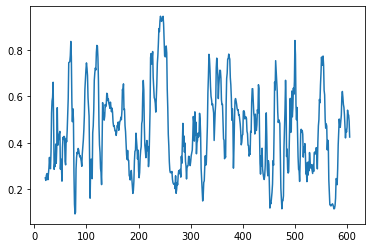

In [ ]:
plt.plot(ls_ind,ls_prob)

In [ ]:
# rep.unsqueeze_(0)

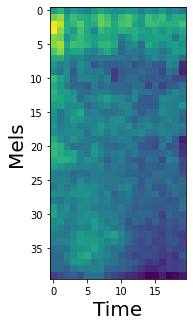

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(rep.to("cpu"))
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
loc = au.T[: 200].T.unsqueeze(0)

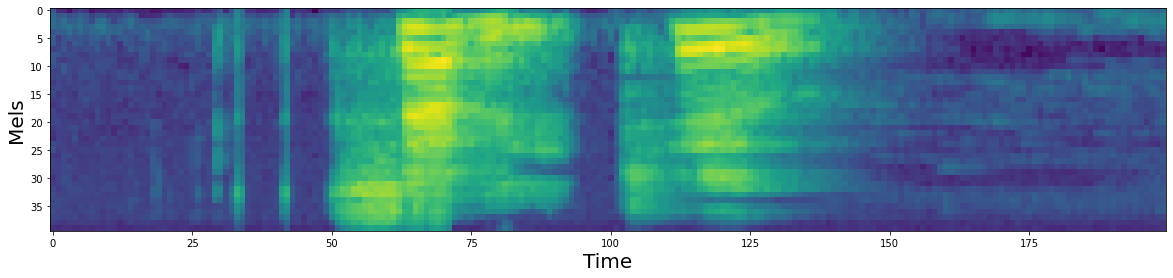

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(loc.squeeze(0).to("cpu"))
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

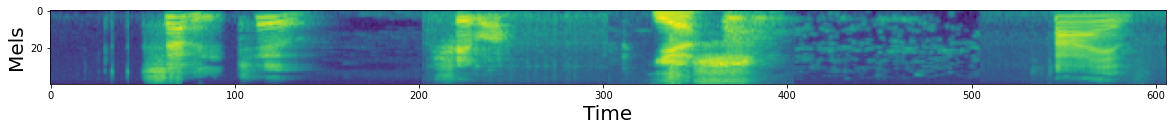

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(au.squeeze(0).to("cpu"))
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
class Attention_(nn.Module):

    def __init__(self, hidden_size: int, is_inference):
        super().__init__()
        self.bufer = None
        self.is_inference = is_inference
        self.energy = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.Tanh(),
            nn.Linear(hidden_size, 1)
        )
    
    def forward(self, input, x = None):
        if not self.is_inference:
            pass
        else:
            if self.bufer is None:
                self.bufer = input
            else:
                self.bufer = torch.vstack((self.bufer, input))
            energy = self.energy(input)
            alpha = torch.softmax(energy, dim=-2)
            return (input * alpha).sum(dim=-2)

class CRNN_(nn.Module):

    def __init__(self, config: TaskConfig, is_inference = False):
        super().__init__()
        self.config = config

        self.bufer = None
        self.initial = True
        self.is_inference = is_inference

        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels=1, out_channels=config.cnn_out_channels,
                kernel_size=config.kernel_size, stride=config.stride
            ),
            nn.Flatten(start_dim=1, end_dim=2),
        )

        self.conv_out_frequency = (config.n_mels - config.kernel_size[0]) // \
            config.stride[0] + 1
        
        self.gru = nn.GRU(
            input_size=self.conv_out_frequency * config.cnn_out_channels,
            hidden_size=config.hidden_size,
            num_layers=config.gru_num_layers,
            dropout=0.1,
            bidirectional=config.bidirectional,
            batch_first=True
        )

        self.attention = Attention_(config.hidden_size, is_inference)
        self.classifier = nn.Linear(config.hidden_size, config.num_classes)

    def forward(self, input, first=False):
        if first:
            self.bufer = None 
        if self.bufer is None:
            self.bufer = input
        else:
            if (input.dim() == 2):
                self.step = input.shape[0]
            if (input.dim() == 3):
                self.step = input.shape[-1]
            self.bufer = self.bufer.T[self.step:].T

            if (input.dim() == 2):
                self.bufer  = torch.cat((self.bufer, input.unsqueeze(2)), dim = -1)
            if ((input.dim() == 3)):
                self.bufer  = torch.cat((self.bufer, input), dim = -1)

        if self.initial:
            input = self.bufer.unsqueeze(dim=1)
            conv_output = self.conv(input).transpose(-1, -2)
            print(conv_output.shape)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output, self.is_inference)
            output = self.classifier(contex_vector)
            self.initial = False
        else:
            input = self.bufer.unsqueeze(dim=1)
            print(input.shape)
            conv_output = self.conv(input).transpose(-1, -2)
            gru_output, _ = self.gru(conv_output)
            contex_vector = self.attention(gru_output, self.is_inference)
            output = self.classifier(contex_vector)
            self.initial = False
        return output

In [ ]:
model_infer = CRNN_(config, is_inference=True).to(config.device)

In [ ]:
checkpoint = torch.load(PATH_base)

In [ ]:
model_infer.load_state_dict(checkpoint)

<All keys matched successfully>

In [ ]:
ls_ind = []
ls_prob = []

max_window_length = 20
rep = au.T[: max_window_length]
with torch.no_grad():
    for i in range(max_window_length,au.shape[1],1):
        if i != max_window_length:
            rep = rep[1:]
            next_T_plus1 =  au.T[i]
            rep = torch.vstack((rep, next_T_plus1))
            # print(rep.T.unsqueeze(0).shape)
            output = model_infer(rep.T.unsqueeze(0)).to("cpu")
            probs = F.softmax(output, dim=-1)
            prob = probs[0][1].item()
            print(i,prob)
            ls_ind.append(i)
            ls_prob.append(prob)
        else:
            output = model_infer(rep.T.unsqueeze(0)).to("cpu")
            probs = F.softmax(output, dim=-1)
            prob = probs[0][1].item()
            print(i,prob)
            ls_ind.append(i)
            ls_prob.append(prob)
rep = rep.T

torch.Size([1, 1, 144])
20 0.21034201979637146
torch.Size([1, 1, 40, 20])
21 0.2255152463912964
torch.Size([1, 1, 40, 20])
22 0.2519547641277313
torch.Size([1, 1, 40, 20])
23 0.3533239960670471
torch.Size([1, 1, 40, 20])
24 0.2881465554237366
torch.Size([1, 1, 40, 20])
25 0.3161696493625641
torch.Size([1, 1, 40, 20])
26 0.20052875578403473
torch.Size([1, 1, 40, 20])
27 0.18534226715564728
torch.Size([1, 1, 40, 20])
28 0.2216782569885254
torch.Size([1, 1, 40, 20])
29 0.3105417788028717
torch.Size([1, 1, 40, 20])
30 0.19742746651172638
torch.Size([1, 1, 40, 20])
31 0.21385696530342102
torch.Size([1, 1, 40, 20])
32 0.32776501774787903
torch.Size([1, 1, 40, 20])
33 0.5579707026481628
torch.Size([1, 1, 40, 20])
34 0.5874226093292236
torch.Size([1, 1, 40, 20])
35 0.6217758655548096
torch.Size([1, 1, 40, 20])
36 0.6012099385261536
torch.Size([1, 1, 40, 20])
37 0.4385751187801361
torch.Size([1, 1, 40, 20])
38 0.24317719042301178
torch.Size([1, 1, 40, 20])
39 0.30985647439956665
torch.Size([1, 

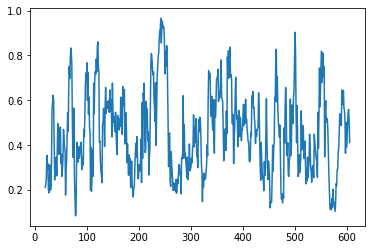

In [ ]:
plt.plot(ls_ind,ls_prob)

In [ ]:
rep = au.T[: max_window_length]
output = model_infer(rep.T.unsqueeze(0)).to("cpu")

torch.Size([1, 1, 40, 20])


In [ ]:
au.T[i:i+5].T.unsqueeze(0).shape

torch.Size([1, 40, 1])

In [ ]:
ls_ind = []
ls_prob = []

rep = au.T[: max_window_length]
model(rep.T.unsqueeze(0)).to("cpu")

for i in range(max_window_length,au.shape[1],5):
    s1 = au.T[i:i+5].T.unsqueeze(0)
    output = model_infer(s1)
    probs = F.softmax(output, dim=-1)
    prob = probs[0][1].item()
    print(i,prob)
    ls_ind.append(i)
    ls_prob.append(prob)


torch.Size([1, 1, 40, 20])
20 0.3699037730693817
torch.Size([1, 1, 40, 20])
25 0.3734433352947235
torch.Size([1, 1, 40, 20])
30 0.5884804725646973
torch.Size([1, 1, 40, 20])
35 0.3306703269481659
torch.Size([1, 1, 40, 20])
40 0.5998743176460266
torch.Size([1, 1, 40, 20])
45 0.4809610843658447
torch.Size([1, 1, 40, 20])
50 0.5192188620567322
torch.Size([1, 1, 40, 20])
55 0.24808353185653687
torch.Size([1, 1, 40, 20])
60 0.49118557572364807
torch.Size([1, 1, 40, 20])
65 0.7796025276184082
torch.Size([1, 1, 40, 20])
70 0.44285085797309875
torch.Size([1, 1, 40, 20])
75 0.09460035711526871
torch.Size([1, 1, 40, 20])
80 0.3840182423591614
torch.Size([1, 1, 40, 20])
85 0.35780730843544006
torch.Size([1, 1, 40, 20])
90 0.5045031905174255
torch.Size([1, 1, 40, 20])
95 0.7492023706436157
torch.Size([1, 1, 40, 20])
100 0.5426830649375916
torch.Size([1, 1, 40, 20])
105 0.23557163774967194
torch.Size([1, 1, 40, 20])
110 0.5662280321121216
torch.Size([1, 1, 40, 20])
115 0.7377761006355286
torch.Size

In [ ]:
s1.shape

torch.Size([1, 40, 1])

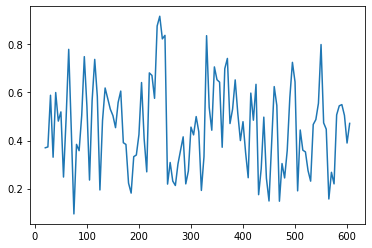

In [ ]:
plt.plot(ls_ind,ls_prob)
None

In [ ]:
rep = au.T[: max_window_length]

In [ ]:
torch.hstack((rep, rep),).shape

torch.Size([20, 80])

In [ ]:
rep.shape

torch.Size([20, 40])

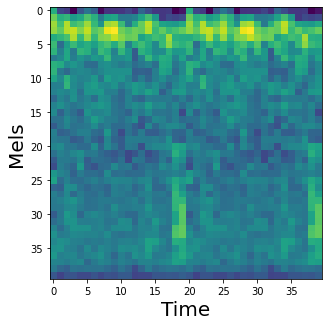

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(torch.hstack((rep.T, rep.T)).squeeze(0).to("cpu"))
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
torch.hstack((rep, rep)).shape

torch.Size([20, 80])

In [ ]:
rep.shape

torch.Size([20, 40])

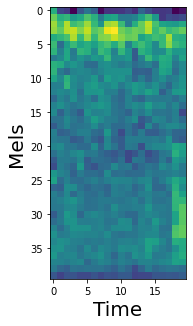

In [ ]:
plt.figure(figsize=(20, 5))
plt.imshow(rep.T.squeeze(0).to("cpu"))
plt.xlabel('Time', size=20)
plt.ylabel('Mels', size=20)
plt.show()

In [ ]:
rep = au.T[: max_window_length]

In [ ]:
s1 = au.T[21:30]

In [ ]:
s1.shape

torch.Size([9, 40])

# Spead UP 💖

Articles: https://arxiv.org/pdf/1503.02531.pdf

Blog 🥇https://medium.com/@mahendrakariya/dark-knowledge-in-neural-networks-467e5d699181

Colab for this article: https://colab.research.google.com/drive/1EI0KiG1q2l6-gpIGHDy9LUSYjcAidt5D#scrollTo=_HOAVYWYZwjn



MUSTHAVE 🥇🥇🥇🥇 https://josehoras.github.io/knowledge-distillation/


In [ ]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [38]:
def my_loss(scores, targets, T=5):
    softmax_op = nn.Softmax(dim=1)
    mseloss_fn = nn.MSELoss()
    soft_pred = softmax_op(scores / T)
    soft_targets = softmax_op(targets / T)
    loss = mseloss_fn(soft_pred, soft_targets)
    return loss

In [39]:
def train_epoch_teach_stud(model_stud, model_teach, my_loss , opt, loader, log_melspec, device):
    model_stud.train()
    model_teach.train()

    for i, (batch, labels) in tqdm(enumerate(loader), total=len(loader)):
        batch, labels = batch.to(device), labels.to(device)
        batch = log_melspec(batch)
        opt.zero_grad()
        with torch.no_grad():
            targets = model_teach(batch)
        scores = model_stud(batch)
        probs = F.softmax(scores, dim=-1)
        loss = my_loss(scores, targets, T = 2)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model_stud.parameters(), 5)

        opt.step()
        # logging
        argmax_probs = torch.argmax(probs, dim=-1)
        FA, FR = count_FA_FR(argmax_probs, labels)
        acc = torch.sum(argmax_probs == labels) / torch.numel(argmax_probs)
    return acc

In [40]:
def get_size_in_megabytes(model):
    num_params = sum([p.numel() for p in model.parameters() if p.requires_grad])
    param_size = next(model.parameters()).element_size()
    return (num_params * param_size) / (2 ** 20)

In [41]:
!pip install thop
from thop import profile  # !pip install thop

In [42]:
!pip install torchsummary

from torchsummary import summary
summary(model, (40, 20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 8, 18, 1]             808
           Flatten-2               [-1, 144, 1]               0
               GRU-3  [[-1, 1, 64], [-1, 2, 64]]               0
            Linear-4                [-1, 1, 64]           4,160
              Tanh-5                [-1, 1, 64]               0
            Linear-6                 [-1, 1, 1]              65
         Attention-7                   [-1, 64]               0
            Linear-8                    [-1, 2]             130
Total params: 5,163
Trainable params: 5,163
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 0.02
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


# Try #1

In [43]:
class TaskConfig_student:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 5
    kernel_size: Tuple[int, int] = (10, 20)
    stride: Tuple[int, int] = (4, 8)
    hidden_size: int = 40
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [44]:
config_stud = TaskConfig_student()
model_stud = CRNN(config_stud).to(config_stud.device)


In [45]:
model_stud(torch.randn(1, 40, 100).to(config_stud.device))

tensor([[ 0.1423, -0.0341]], device='cuda:0', grad_fn=<AddmmBackward>)

In [46]:
sum([p.numel() for p in model.parameters()])

70443

In [ ]:
sum([p.numel() for p in model_stud.parameters()])

22448

In [ ]:
opt = torch.optim.Adam(
    model_stud.parameters(),
    lr=config_stud.learning_rate,
    weight_decay=config_stud.weight_decay
)
history = defaultdict(list)

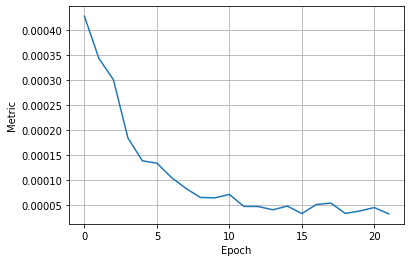

END OF EPOCH 21


 27%|██▋       | 108/405 [00:10<00:30,  9.89it/s]


KeyboardInterrupt: ignored

In [ ]:
# TRAIN
for n in range(TaskConfig_student.num_epochs):

    train_epoch_teach_stud(model_stud, model, my_loss, opt, train_loader, melspec_train, config.device)

    au_fa_fr = validation(model_stud, val_loader,
                          melspec_val, config.device)
    print(au_fa_fr)
    history['val_metric'].append(au_fa_fr)

    clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
validation(model, val_loader, melspec_val, config.device)

102it [00:05, 18.53it/s]


2.515918060200918e-05

In [ ]:
validation(model_stud, val_loader, melspec_val, config.device)

102it [00:05, 19.33it/s]


0.01905634274967585

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0004281834740406459,
              0.00034365017878026607,
              0.0003009822135752458,
              0.00018440915535182346,
              0.00013847097407234846,
              0.00013385209224456025,
              0.00010519592876001372,
              8.329502913729701e-05,
              6.507610637213239e-05,
              6.428839009142432e-05,
              7.114510226213318e-05,
              4.7161528533604975e-05,
              4.6904923987616735e-05,
              4.035255674354509e-05,
              4.779408857720388e-05,
              3.26902256493848e-05,
              5.092705105729279e-05,
              5.377357125348785e-05,
              3.307214869457659e-05,
              3.794763506835303e-05,
              4.4887892905197594e-05,
              3.209347089127262e-05]})

In [ ]:
!pip install torchsummary

from torchsummary import summary
summary(model_stud, (40, 20))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1              [-1, 5, 8, 1]           1,005
           Flatten-2                [-1, 40, 1]               0
               GRU-3  [[-1, 1, 40], [-1, 2, 40]]               0
            Linear-4                [-1, 1, 40]           1,640
              Tanh-5                [-1, 1, 40]               0
            Linear-6                 [-1, 1, 1]              41
         Attention-7                   [-1, 40]               0
            Linear-8                    [-1, 2]              82
Total params: 2,768
Trainable params: 2,768
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 0.01
Estimated Total Size (MB): 0.04
----------------------------------------------------------------


In [ ]:
get_size_in_megabytes(model) / get_size_in_megabytes(model_stud) 

3.138052387740556

In [ ]:
torch.save(model_stud.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/model_try2.pt') 

### Load model

In [47]:
!gdown --id  1-0k0RCN9sdReIOkKsBUpsUkJsJUOYKq8

Downloading...
From: https://drive.google.com/uc?id=1-0k0RCN9sdReIOkKsBUpsUkJsJUOYKq8
To: /content/model_try2.pt
100% 93.3k/93.3k [00:00<00:00, 36.6MB/s]


In [48]:
PATH_base1 = '/content/model_try2.pt'

In [49]:
model_stud = CRNN(config_stud).to(config_stud.device)
checkpoint = torch.load(PATH_base1)

In [50]:
model_stud.load_state_dict(checkpoint)

<All keys matched successfully>

In [51]:
validation(model_stud, val_loader, melspec_val, config.device)

102it [00:07, 14.54it/s]


3.587092851012268e-05

In [ ]:
profile(model_stud, inputs=(torch.randn(1, 40, 100).to("cuda:0"), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(329200.0, 22448.0)

# Try 2 unsuccessful

In [52]:
class TaskConfig_student_2:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 4
    kernel_size: Tuple[int, int] = (9, 20)
    stride: Tuple[int, int] = (5, 8)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [53]:
config_stud = TaskConfig_student_2()
model_stud_2 = CRNN(config_stud).to(config_stud.device)

In [ ]:
profile(model_stud_2, inputs=(input, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(124208.0, 6727.0)

In [ ]:
sum([p.numel() for p in model_stud_2.parameters()])

6727

In [ ]:
opt = torch.optim.Adam(
    model_stud_2.parameters(),
    lr=config_stud.learning_rate,
    weight_decay=config_stud.weight_decay
)
history = defaultdict(list)

100%|██████████| 405/405 [00:52<00:00,  7.67it/s]
102it [00:07, 14.51it/s]


0.0011348306208591747
[0.001]


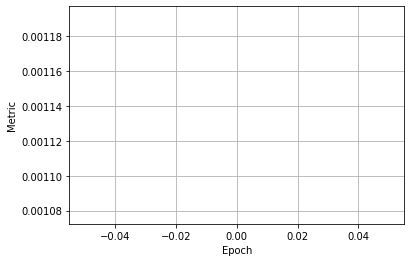

END OF EPOCH 0


100%|██████████| 405/405 [00:53<00:00,  7.62it/s]
102it [00:07, 14.15it/s]


0.0006311755725600823
[0.001]


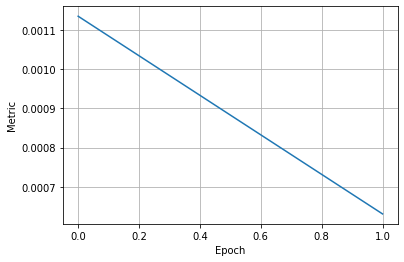

END OF EPOCH 1


100%|██████████| 405/405 [00:52<00:00,  7.65it/s]
102it [00:07, 14.19it/s]


0.0004664861781900756
[0.001]


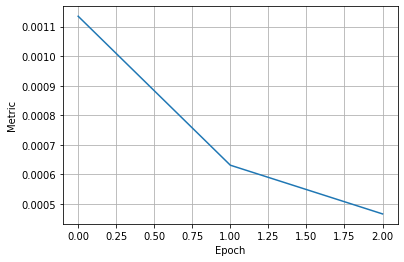

END OF EPOCH 2


100%|██████████| 405/405 [00:53<00:00,  7.59it/s]
102it [00:07, 14.31it/s]
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/queues.py", line 242, in _feed
    send_bytes(obj)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 200, in send_bytes
    self._send_bytes(m[offset:offset + size])
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 404, in _send_bytes
    self._send(header + buf)
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 368, in _send
    n = write(self._handle, buf)
BrokenPipeError: [Errno 32] Broken pipe
Exception ignored in: <function _ConnectionBase.__del__ at 0x7f0bc7f4eb90>
Traceback (most recent call last):
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 132, in __del__
    self._close()
  File "/usr/lib/python3.7/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


0.0003878130146543573
[0.001]


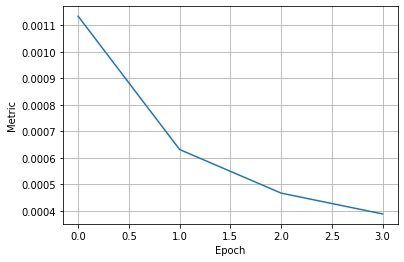

END OF EPOCH 3


100%|██████████| 405/405 [00:53<00:00,  7.52it/s]
102it [00:07, 14.37it/s]


0.0002745579128860388
[0.001]


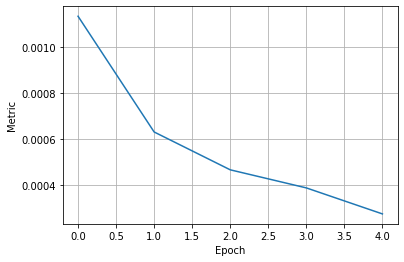

END OF EPOCH 4


100%|██████████| 405/405 [00:52<00:00,  7.66it/s]
102it [00:07, 14.18it/s]


0.0002508936029531006
[0.001]


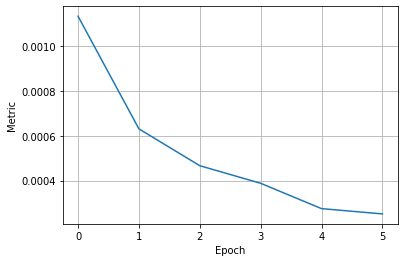

END OF EPOCH 5


100%|██████████| 405/405 [00:53<00:00,  7.61it/s]
102it [00:07, 14.08it/s]


0.00020510759413694418
[0.001]


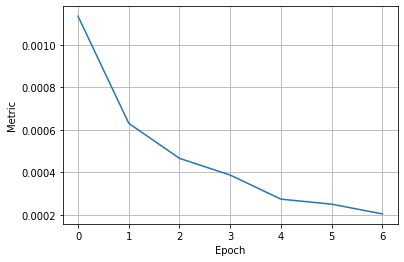

END OF EPOCH 6


100%|██████████| 405/405 [00:53<00:00,  7.59it/s]
102it [00:07, 13.98it/s]


0.00018800161899565874
[0.001]


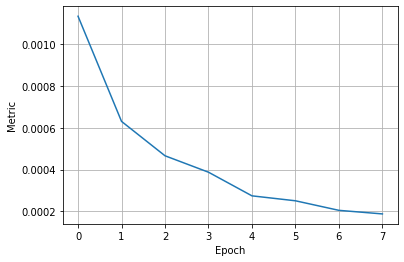

END OF EPOCH 7


100%|██████████| 405/405 [00:53<00:00,  7.54it/s]
102it [00:07, 14.20it/s]


0.00017696762351816469
[0.001]


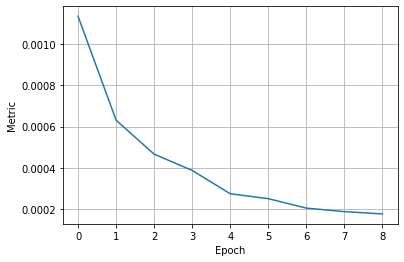

END OF EPOCH 8


100%|██████████| 405/405 [00:53<00:00,  7.55it/s]
102it [00:07, 14.32it/s]


0.0001445877103429982
[0.0003]


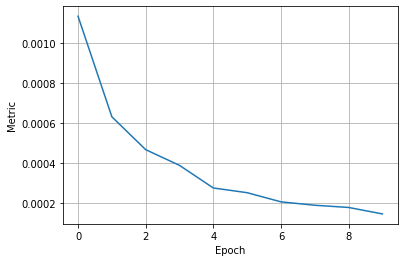

END OF EPOCH 9


100%|██████████| 405/405 [00:54<00:00,  7.42it/s]
102it [00:07, 14.34it/s]


0.00012484706294464757
[0.0003]


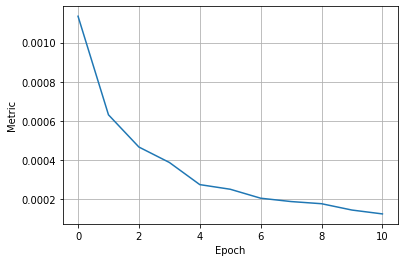

END OF EPOCH 10


100%|██████████| 405/405 [00:52<00:00,  7.65it/s]
102it [00:07, 14.04it/s]


0.0001243517564954145
[0.0003]


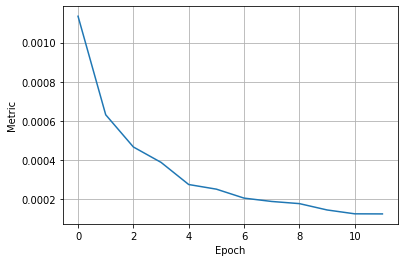

END OF EPOCH 11


100%|██████████| 405/405 [00:53<00:00,  7.58it/s]
102it [00:07, 13.62it/s]


0.00013462787343010608
[0.0003]


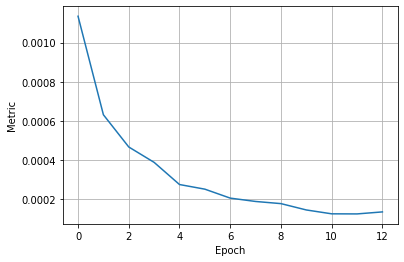

END OF EPOCH 12


100%|██████████| 405/405 [00:55<00:00,  7.31it/s]
102it [00:07, 14.04it/s]


0.000117709876037626
[0.0003]


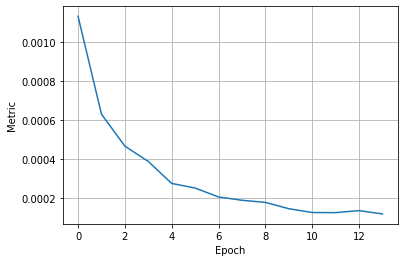

END OF EPOCH 13


100%|██████████| 405/405 [00:53<00:00,  7.52it/s]
102it [00:07, 14.36it/s]


0.00013214537363635944
[0.0003]


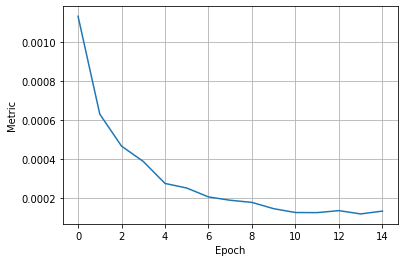

END OF EPOCH 14


100%|██████████| 405/405 [00:54<00:00,  7.47it/s]
102it [00:07, 14.07it/s]


0.00012668506759963306
[0.0003]


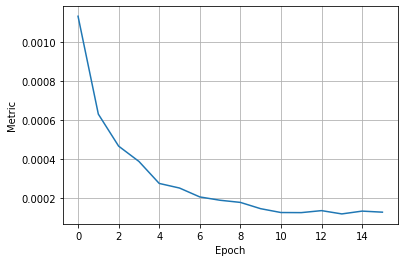

END OF EPOCH 15


100%|██████████| 405/405 [00:54<00:00,  7.43it/s]
102it [00:07, 13.94it/s]


0.00011286124362796458
[0.0003]


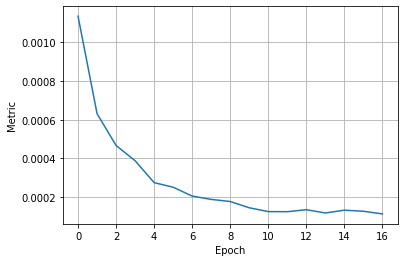

END OF EPOCH 16


100%|██████████| 405/405 [00:54<00:00,  7.41it/s]
102it [00:07, 14.21it/s]


0.00011500060943579673
[0.0003]


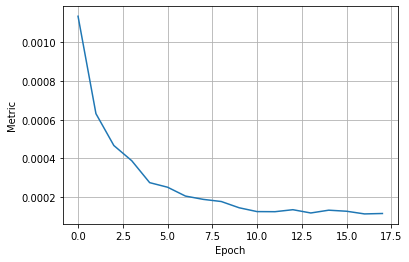

END OF EPOCH 17


100%|██████████| 405/405 [00:53<00:00,  7.54it/s]
102it [00:07, 14.11it/s]


0.00010934934187647445
[0.0003]


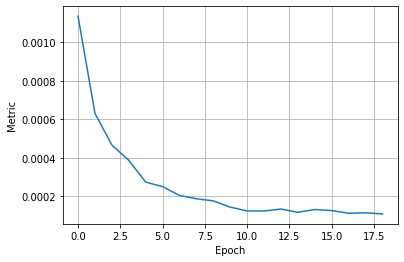

END OF EPOCH 18


100%|██████████| 405/405 [00:54<00:00,  7.43it/s]
102it [00:07, 13.50it/s]


0.00011771584358520711
[8.999999999999999e-05]


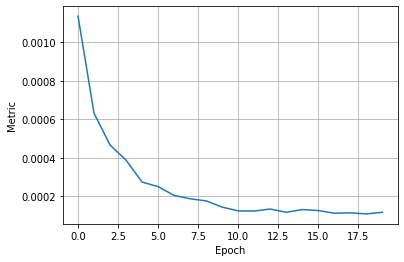

END OF EPOCH 19


100%|██████████| 405/405 [00:54<00:00,  7.48it/s]
102it [00:07, 14.31it/s]


0.00010669378320287529
[8.999999999999999e-05]


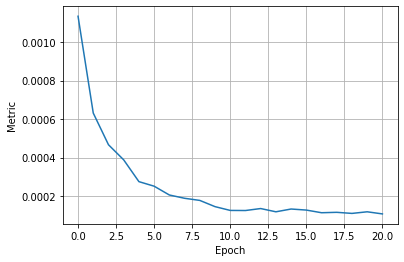

END OF EPOCH 20


100%|██████████| 405/405 [00:53<00:00,  7.51it/s]
102it [00:07, 14.50it/s]


0.00010009367557815465
[8.999999999999999e-05]


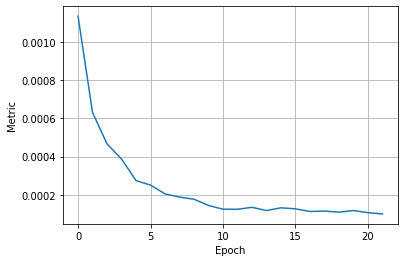

END OF EPOCH 21


100%|██████████| 405/405 [00:54<00:00,  7.44it/s]
102it [00:07, 14.21it/s]


0.00010009964312573578
[8.999999999999999e-05]


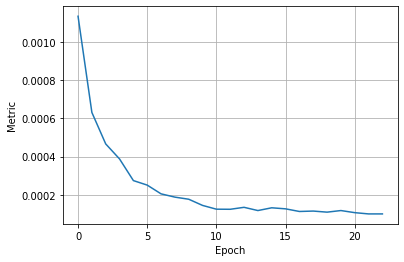

END OF EPOCH 22


100%|██████████| 405/405 [00:53<00:00,  7.56it/s]
102it [00:07, 13.72it/s]


9.459159670836043e-05
[8.999999999999999e-05]


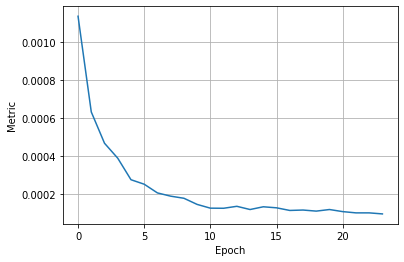

END OF EPOCH 23


100%|██████████| 405/405 [00:53<00:00,  7.57it/s]
102it [00:07, 14.15it/s]


0.00010326542711752086
[8.999999999999999e-05]


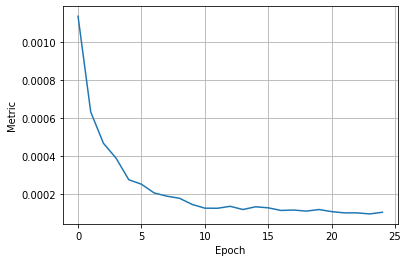

END OF EPOCH 24


100%|██████████| 405/405 [00:54<00:00,  7.47it/s]
102it [00:07, 14.09it/s]


9.847945395746122e-05
[8.999999999999999e-05]


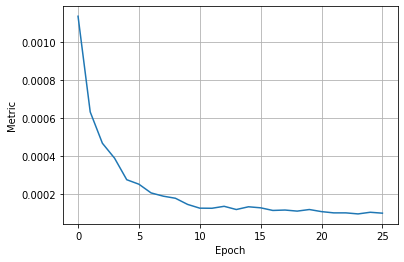

END OF EPOCH 25


100%|██████████| 405/405 [00:53<00:00,  7.56it/s]
102it [00:07, 13.87it/s]


0.00010062777108666506
[8.999999999999999e-05]


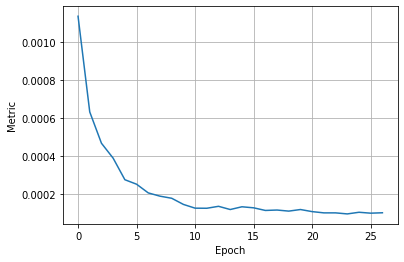

END OF EPOCH 26


100%|██████████| 405/405 [00:55<00:00,  7.34it/s]
102it [00:07, 14.34it/s]


9.141089384762255e-05
[8.999999999999999e-05]


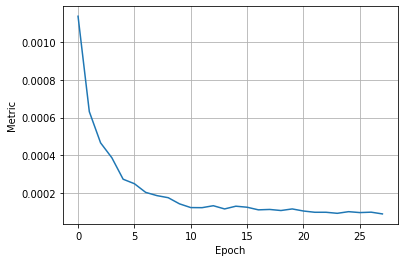

END OF EPOCH 27


100%|██████████| 405/405 [00:53<00:00,  7.56it/s]
102it [00:07, 14.21it/s]


9.03486703781829e-05
[8.999999999999999e-05]


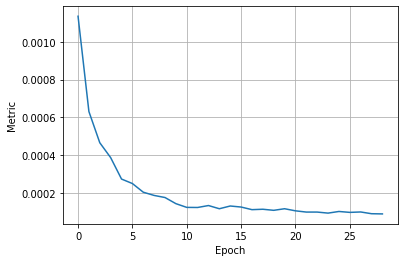

END OF EPOCH 28


100%|██████████| 405/405 [00:53<00:00,  7.55it/s]
102it [00:07, 14.20it/s]


9.446031066157576e-05
[2.6999999999999996e-05]


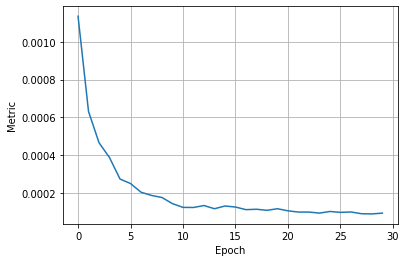

END OF EPOCH 29


100%|██████████| 405/405 [00:53<00:00,  7.53it/s]
102it [00:07, 14.46it/s]


8.891049141113254e-05
[2.6999999999999996e-05]


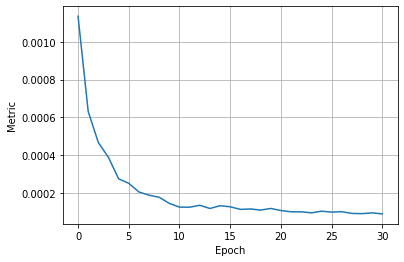

END OF EPOCH 30


100%|██████████| 405/405 [00:54<00:00,  7.47it/s]
102it [00:07, 13.79it/s]


8.718587016018838e-05
[2.6999999999999996e-05]


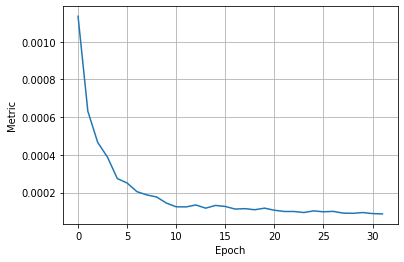

END OF EPOCH 31


100%|██████████| 405/405 [00:53<00:00,  7.53it/s]
102it [00:07, 13.87it/s]


8.62907380230201e-05
[2.6999999999999996e-05]


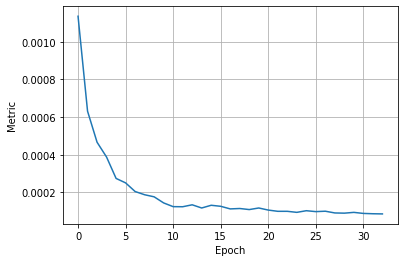

END OF EPOCH 32


100%|██████████| 405/405 [00:53<00:00,  7.59it/s]
102it [00:07, 13.83it/s]


8.805713210703214e-05
[2.6999999999999996e-05]


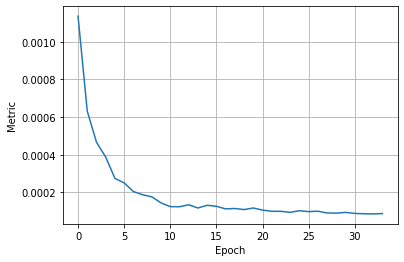

END OF EPOCH 33


100%|██████████| 405/405 [00:54<00:00,  7.45it/s]
102it [00:07, 14.37it/s]


8.699490863759247e-05
[2.6999999999999996e-05]


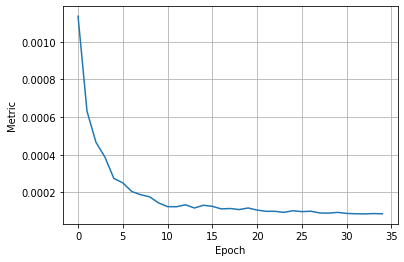

END OF EPOCH 34


100%|██████████| 405/405 [00:52<00:00,  7.70it/s]
102it [00:06, 14.67it/s]


8.865985441272545e-05
[2.6999999999999996e-05]


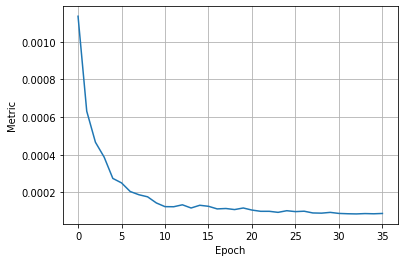

END OF EPOCH 35


100%|██████████| 405/405 [00:52<00:00,  7.73it/s]
102it [00:07, 14.52it/s]


8.715603242228276e-05
[2.6999999999999996e-05]


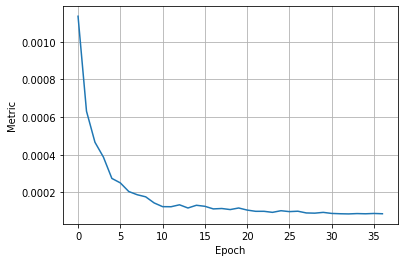

END OF EPOCH 36


100%|██████████| 405/405 [00:53<00:00,  7.59it/s]
102it [00:07, 14.30it/s]


8.603413347703187e-05
[2.6999999999999996e-05]


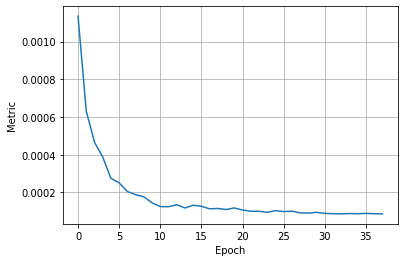

END OF EPOCH 37


100%|██████████| 405/405 [00:52<00:00,  7.73it/s]
102it [00:07, 14.10it/s]


8.393952427605815e-05
[2.6999999999999996e-05]


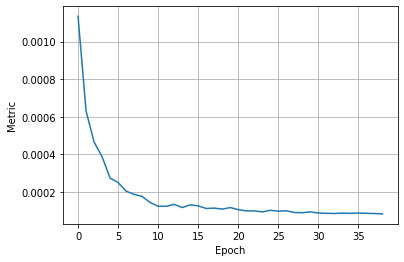

END OF EPOCH 38


100%|██████████| 405/405 [00:53<00:00,  7.60it/s]
102it [00:07, 13.70it/s]


8.353373104054186e-05
[8.099999999999999e-06]


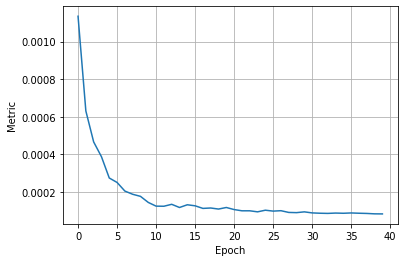

END OF EPOCH 39


100%|██████████| 405/405 [00:53<00:00,  7.62it/s]
102it [00:07, 13.87it/s]


8.404694013251834e-05
[8.099999999999999e-06]


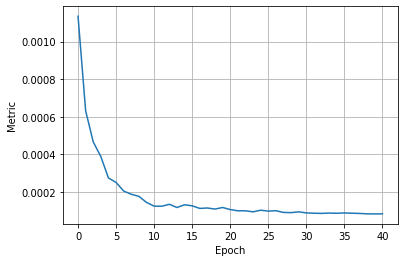

END OF EPOCH 40


100%|██████████| 405/405 [00:53<00:00,  7.63it/s]
102it [00:07, 14.29it/s]


8.370678992039441e-05
[8.099999999999999e-06]


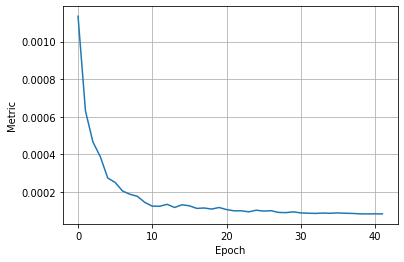

END OF EPOCH 41


100%|██████████| 405/405 [00:54<00:00,  7.39it/s]
102it [00:07, 14.01it/s]


8.407677787042396e-05
[8.099999999999999e-06]


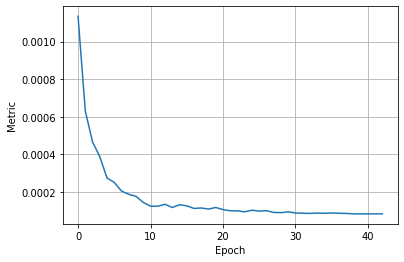

END OF EPOCH 42


100%|██████████| 405/405 [00:53<00:00,  7.53it/s]
102it [00:07, 14.05it/s]


8.40648427752617e-05
[8.099999999999999e-06]


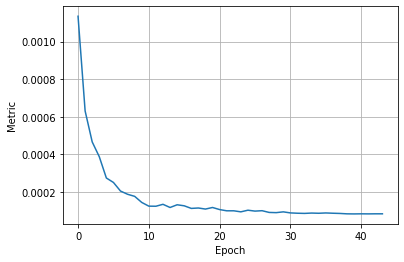

END OF EPOCH 43


100%|██████████| 405/405 [00:54<00:00,  7.47it/s]
102it [00:07, 14.07it/s]


8.460192205756265e-05
[8.099999999999999e-06]


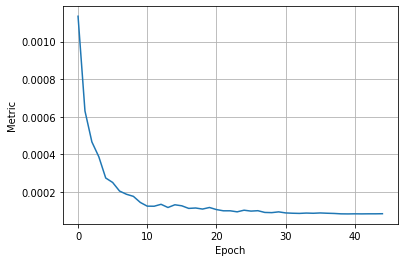

END OF EPOCH 44


100%|██████████| 405/405 [00:54<00:00,  7.43it/s]
102it [00:07, 13.66it/s]


8.355163368328523e-05
[8.099999999999999e-06]


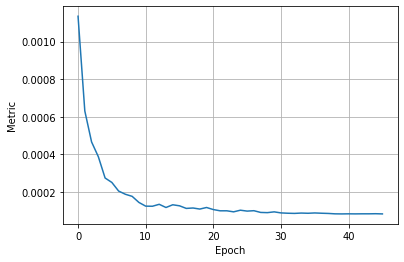

END OF EPOCH 45


100%|██████████| 405/405 [00:53<00:00,  7.51it/s]
102it [00:07, 13.81it/s]


8.231038378641191e-05
[8.099999999999999e-06]


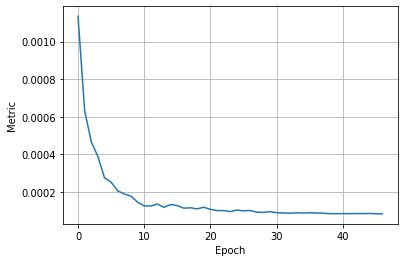

END OF EPOCH 46


100%|██████████| 405/405 [00:53<00:00,  7.52it/s]
102it [00:07, 13.84it/s]


8.197620112186911e-05
[8.099999999999999e-06]


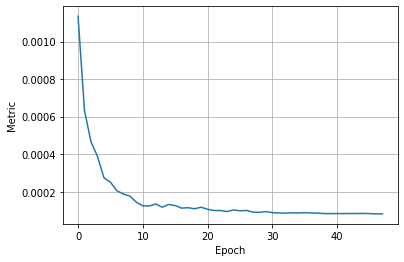

END OF EPOCH 47


100%|██████████| 405/405 [00:53<00:00,  7.52it/s]
102it [00:07, 13.72it/s]


8.217909773962725e-05
[8.099999999999999e-06]


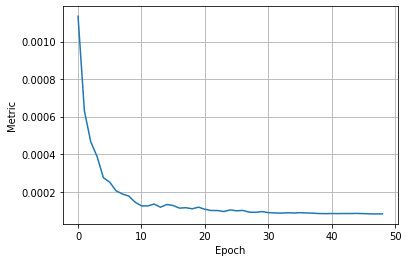

END OF EPOCH 48


100%|██████████| 405/405 [00:53<00:00,  7.60it/s]
102it [00:07, 14.14it/s]


8.131977088794573e-05
[2.4299999999999996e-06]


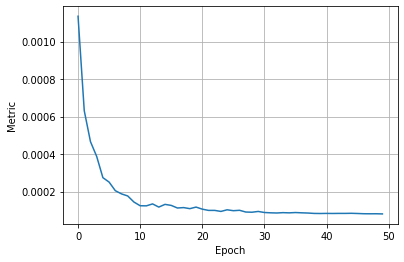

END OF EPOCH 49


100%|██████████| 405/405 [00:54<00:00,  7.40it/s]
102it [00:07, 13.72it/s]


8.132573843552682e-05
[2.4299999999999996e-06]


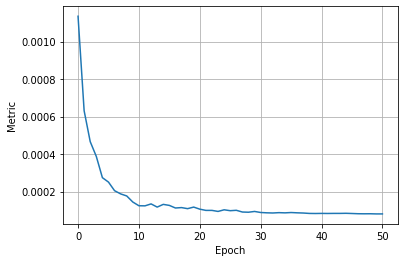

END OF EPOCH 50


100%|██████████| 405/405 [00:53<00:00,  7.51it/s]
102it [00:07, 13.84it/s]


8.09855882234029e-05
[2.4299999999999996e-06]


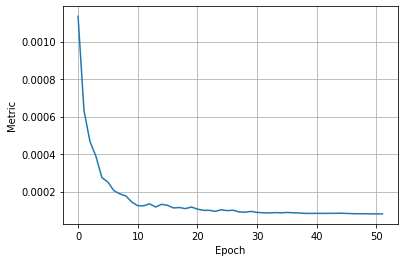

END OF EPOCH 51


100%|██████████| 405/405 [00:55<00:00,  7.28it/s]
102it [00:07, 13.79it/s]


8.103034483026132e-05
[2.4299999999999996e-06]


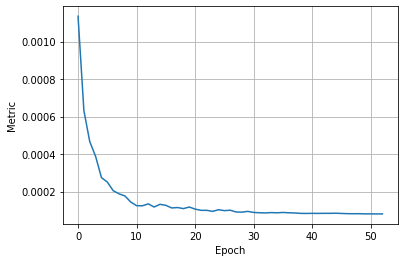

END OF EPOCH 52


 28%|██▊       | 114/405 [00:15<00:40,  7.26it/s]


KeyboardInterrupt: ignored

In [ ]:
# TRAIN
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=10, gamma=0.3)

for n in range(TaskConfig_student_2.num_epochs):

    train_epoch_teach_stud(model_stud_2, model, my_loss, opt, train_loader, melspec_train, config_stud.device)

    au_fa_fr = validation(model_stud_2, val_loader,
                          melspec_val, config_stud.device)
    print(au_fa_fr)
    scheduler.step()
    print(scheduler.get_last_lr())
    history['val_metric'].append(au_fa_fr)

    # clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0011348306208591747,
              0.0006311755725600823,
              0.0004664861781900756,
              0.0003878130146543573,
              0.0002745579128860388,
              0.0002508936029531006,
              0.00020510759413694418,
              0.00018800161899565874,
              0.00017696762351816469,
              0.0001445877103429982,
              0.00012484706294464757,
              0.0001243517564954145,
              0.00013462787343010608,
              0.000117709876037626,
              0.00013214537363635944,
              0.00012668506759963306,
              0.00011286124362796458,
              0.00011500060943579673,
              0.00010934934187647445,
              0.00011771584358520711,
              0.00010669378320287529,
              0.00010009367557815465,
              0.00010009964312573578,
              9.459159670836043e-05,
              0.00010326542711752086,
              9.8479453957461

In [ ]:
torch.save(model_stud_2.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/student2_model_notlearn.pt') 

In [ ]:
model_stud_2

CRNN_student(
  (conv): Sequential(
    (0): Conv2d(1, 5, kernel_size=(10, 20), stride=(5, 8))
    (1): Flatten(start_dim=1, end_dim=2)
  )
  (gru): GRU(35, 20, num_layers=2, batch_first=True, dropout=0.1)
  (attention): Attention_stud(
    (energy): Sequential(
      (0): Linear(in_features=20, out_features=20, bias=True)
      (1): Tanh()
      (2): Linear(in_features=20, out_features=1, bias=True)
    )
  )
  (classifier): Linear(in_features=20, out_features=2, bias=True)
)

In [ ]:
model_stud_2(torch.randn(1, 40, 101).to(config_stud.device))

tensor([[ 0.7576, -0.7016]], device='cuda:0', grad_fn=<AddmmBackward>)

In [ ]:
get_size_in_megabytes(model) / get_size_in_megabytes(model_stud_2) 

10.471681284376393

### Load model

In [ ]:
!gdown --id  1aLa_8URz-JL1ssVuFPW7L_p6EXlRAVR5

Downloading...
From: https://drive.google.com/uc?id=1aLa_8URz-JL1ssVuFPW7L_p6EXlRAVR5
To: /content/student2_model_notlearn.pt
100% 33.8k/33.8k [00:00<00:00, 16.9MB/s]


In [ ]:
PATH_base2 = '/content/student2_model_notlearn.pt'

In [ ]:
model_stud = CRNN(config_stud).to(config_stud.device)
checkpoint = torch.load(PATH_base2)

In [ ]:
model_stud.load_state_dict(checkpoint)

RuntimeError: ignored

In [ ]:
validation(model_stud, val_loader, melspec_val, config.device)

102it [00:05, 18.64it/s]


8.113477691293093e-05

# Try 3

In [54]:
class TaskConfig_student_3:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 5
    kernel_size: Tuple[int, int] = (12, 20)
    stride: Tuple[int, int] = (5, 8)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [55]:
config_stud3 = TaskConfig_student_3()
model_stud_3 = CRNN(config_stud3).to(config_stud3.device)

In [56]:
input.shape

torch.Size([1, 40, 100])

In [57]:
profile(model_stud_3, inputs=(input, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(149310.0, 7328.0)

In [ ]:
sum([p.numel() for p in model_stud_3.parameters()])

7328

In [ ]:
opt = torch.optim.Adam(
    model_stud_3.parameters(),
    lr=config_stud3.learning_rate,
    weight_decay=config_stud3.weight_decay
)
history = defaultdict(list)

100%|██████████| 405/405 [00:41<00:00,  9.72it/s]
102it [00:05, 18.42it/s]


0.0009386087050705207
[0.001]


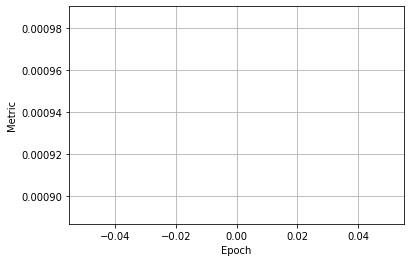

END OF EPOCH 0


100%|██████████| 405/405 [00:41<00:00,  9.85it/s]
102it [00:05, 18.18it/s]


0.0008554897185868667
[0.001]


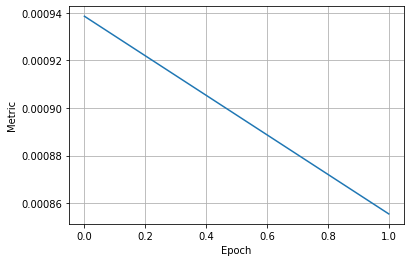

END OF EPOCH 1


100%|██████████| 405/405 [00:41<00:00,  9.86it/s]
102it [00:05, 18.49it/s]


0.000547516523020337
[0.001]


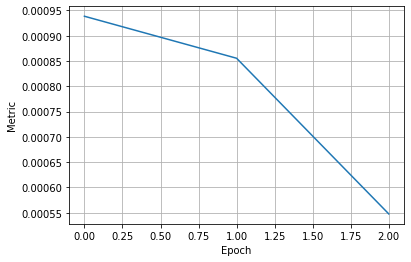

END OF EPOCH 2


100%|██████████| 405/405 [00:41<00:00,  9.88it/s]
102it [00:05, 18.86it/s]


0.00040121314274776617
[0.001]


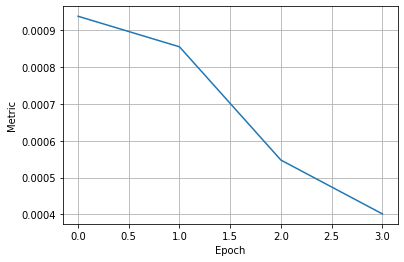

END OF EPOCH 3


100%|██████████| 405/405 [00:41<00:00,  9.86it/s]
102it [00:05, 18.79it/s]


0.0003658464720082483
[0.001]


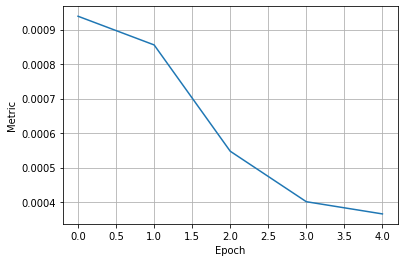

END OF EPOCH 4


100%|██████████| 405/405 [00:40<00:00, 10.07it/s]
102it [00:05, 18.89it/s]


0.00023385625460899806
[0.001]


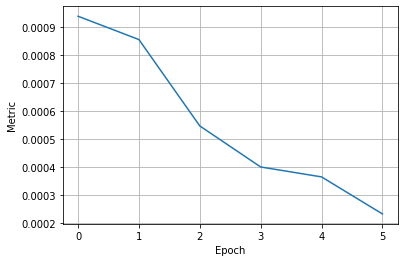

END OF EPOCH 5


100%|██████████| 405/405 [00:41<00:00,  9.82it/s]
102it [00:05, 18.41it/s]


0.00022527492118734502
[0.001]


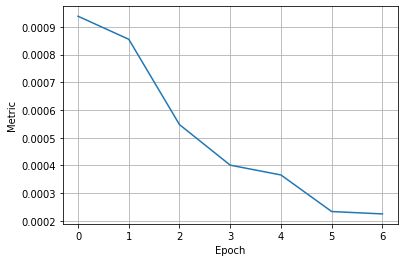

END OF EPOCH 6


100%|██████████| 405/405 [00:41<00:00,  9.84it/s]
102it [00:05, 18.47it/s]


0.0002049315514833011
[0.001]


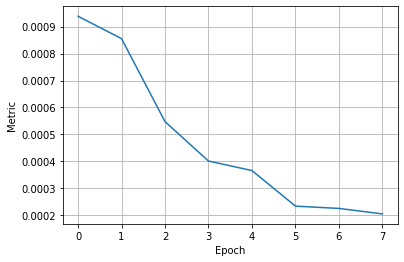

END OF EPOCH 7


100%|██████████| 405/405 [00:41<00:00,  9.79it/s]
102it [00:05, 17.56it/s]


0.00018464188970748725
[0.001]


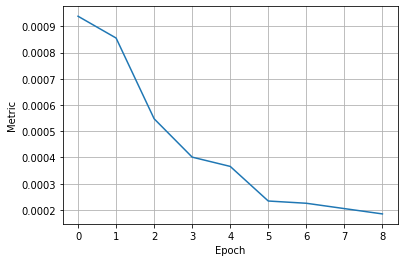

END OF EPOCH 8


100%|██████████| 405/405 [00:42<00:00,  9.51it/s]
102it [00:05, 17.97it/s]


0.00022989081924134272
[0.001]


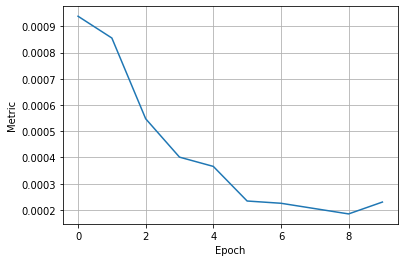

END OF EPOCH 9


100%|██████████| 405/405 [00:42<00:00,  9.58it/s]
102it [00:06, 16.88it/s]


0.00016457899473975597
[0.001]


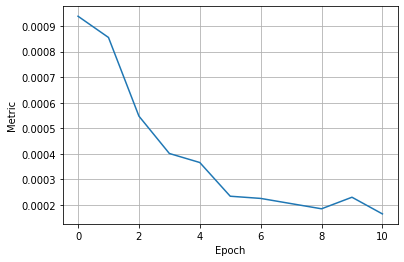

END OF EPOCH 10


100%|██████████| 405/405 [00:42<00:00,  9.56it/s]
102it [00:05, 18.46it/s]


0.00016117749261851662
[0.001]


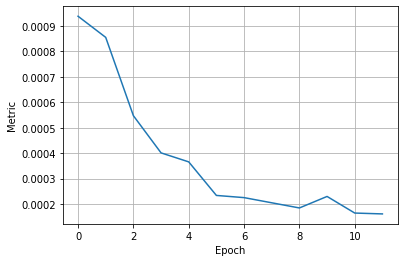

END OF EPOCH 11


100%|██████████| 405/405 [00:42<00:00,  9.61it/s]
102it [00:05, 17.70it/s]


0.00013440707416960456
[0.001]


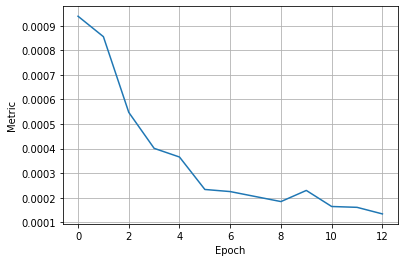

END OF EPOCH 12


100%|██████████| 405/405 [00:42<00:00,  9.57it/s]
102it [00:05, 17.76it/s]


0.0001558126673430882
[0.0006]


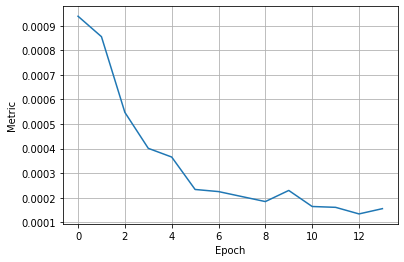

END OF EPOCH 13


100%|██████████| 405/405 [00:43<00:00,  9.35it/s]
102it [00:05, 17.89it/s]


0.00012644039814880707
[0.0006]


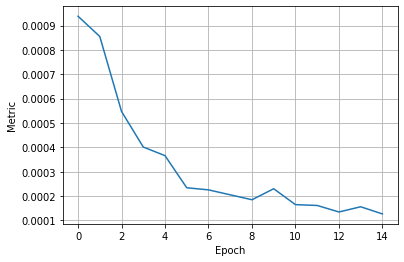

END OF EPOCH 14


100%|██████████| 405/405 [00:43<00:00,  9.40it/s]
102it [00:05, 17.56it/s]


0.00011703554316095924
[0.0006]


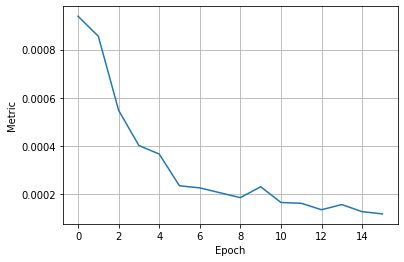

END OF EPOCH 15


100%|██████████| 405/405 [00:42<00:00,  9.48it/s]
102it [00:05, 17.50it/s]


0.00012063397435237562
[0.0006]


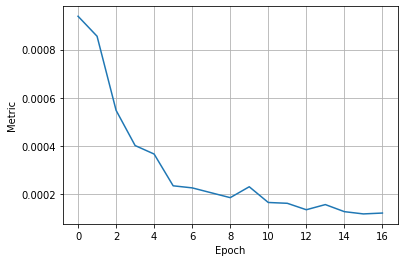

END OF EPOCH 16


100%|██████████| 405/405 [00:42<00:00,  9.57it/s]
102it [00:05, 17.65it/s]


0.00012438756178090118
[0.0006]


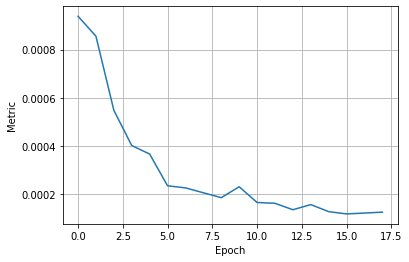

END OF EPOCH 17


100%|██████████| 405/405 [00:42<00:00,  9.58it/s]
102it [00:05, 17.58it/s]


0.00010394274376797817
[0.0006]


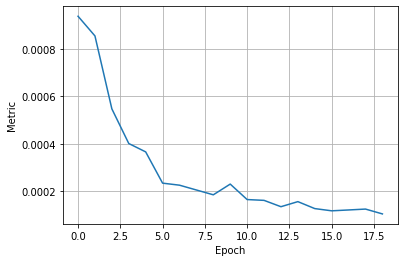

END OF EPOCH 18


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.70it/s]


0.00010090227827539664
[0.0006]


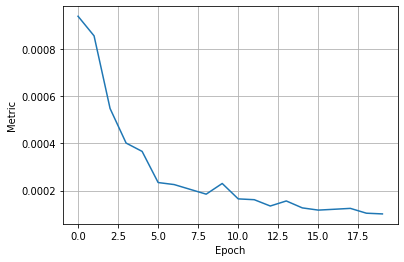

END OF EPOCH 19


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.70it/s]


9.557027451166438e-05
[0.0006]


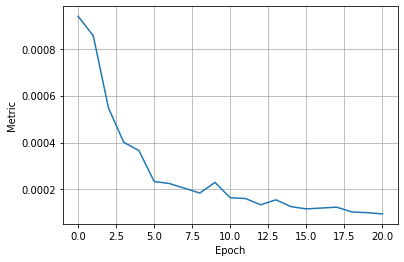

END OF EPOCH 20


100%|██████████| 405/405 [00:42<00:00,  9.52it/s]
102it [00:05, 17.83it/s]


8.537770324310849e-05
[0.0006]


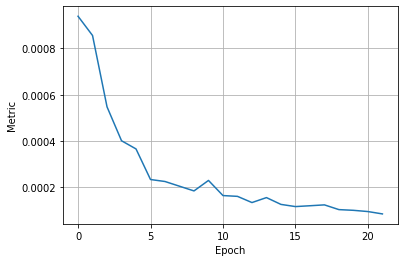

END OF EPOCH 21


100%|██████████| 405/405 [00:42<00:00,  9.47it/s]
102it [00:05, 17.58it/s]


8.382017332443572e-05
[0.0006]


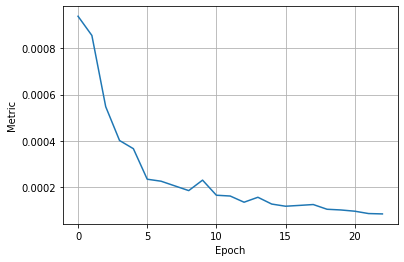

END OF EPOCH 22


100%|██████████| 405/405 [00:42<00:00,  9.49it/s]
102it [00:05, 17.70it/s]


8.108703653228198e-05
[0.0006]


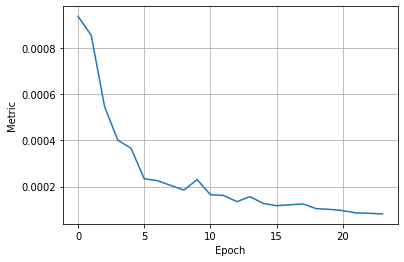

END OF EPOCH 23


100%|██████████| 405/405 [00:41<00:00,  9.70it/s]
102it [00:05, 18.12it/s]


8.300858685340316e-05
[0.0006]


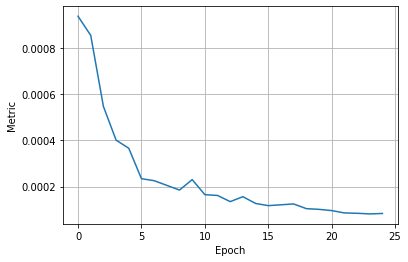

END OF EPOCH 24


100%|██████████| 405/405 [00:42<00:00,  9.58it/s]
102it [00:05, 17.72it/s]


6.699765669325358e-05
[0.0006]


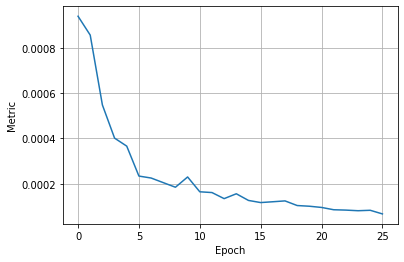

END OF EPOCH 25


100%|██████████| 405/405 [00:42<00:00,  9.43it/s]
102it [00:05, 17.54it/s]


6.914597382245741e-05
[0.0006]


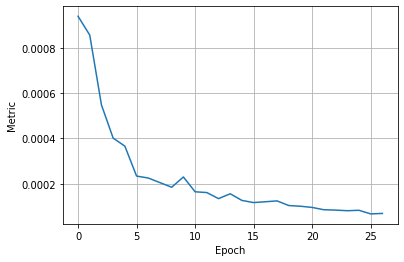

END OF EPOCH 26


100%|██████████| 405/405 [00:43<00:00,  9.42it/s]
102it [00:05, 17.50it/s]


7.650395998998048e-05
[0.00035999999999999997]


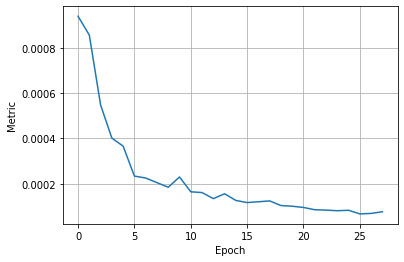

END OF EPOCH 27


100%|██████████| 405/405 [00:42<00:00,  9.46it/s]
102it [00:05, 17.43it/s]


6.306504283729437e-05
[0.00035999999999999997]


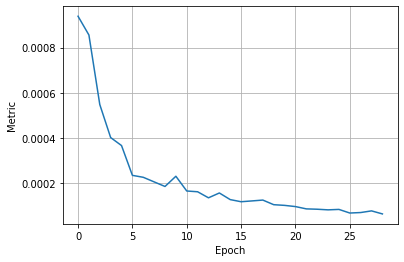

END OF EPOCH 28


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.29it/s]


6.39004994986514e-05
[0.00035999999999999997]


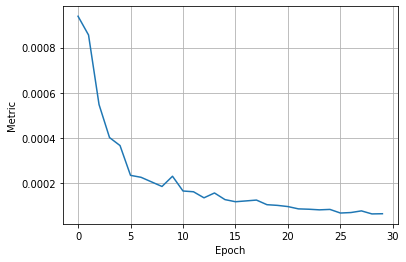

END OF EPOCH 29


100%|██████████| 405/405 [00:43<00:00,  9.31it/s]
102it [00:05, 17.63it/s]


5.9782891667677416e-05
[0.00035999999999999997]


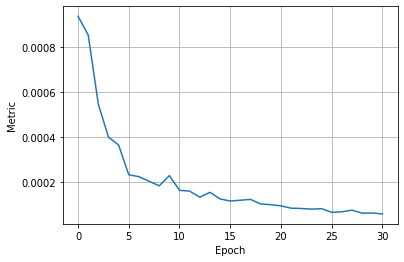

END OF EPOCH 30


100%|██████████| 405/405 [00:43<00:00,  9.30it/s]
102it [00:05, 17.19it/s]


5.714225186303106e-05
[0.00035999999999999997]


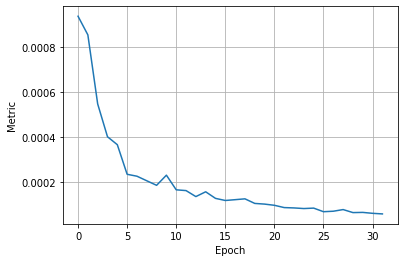

END OF EPOCH 31


100%|██████████| 405/405 [00:42<00:00,  9.43it/s]
102it [00:05, 17.25it/s]


5.766441227637921e-05
[0.00035999999999999997]


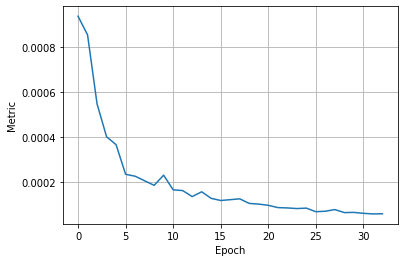

END OF EPOCH 32


100%|██████████| 405/405 [00:43<00:00,  9.39it/s]
102it [00:05, 17.55it/s]


5.747941830136443e-05
[0.00035999999999999997]


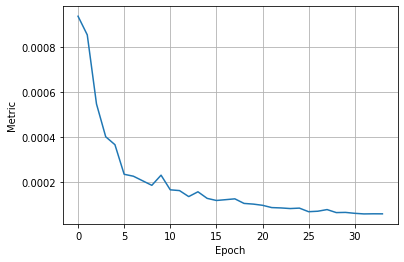

END OF EPOCH 33


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.51it/s]


5.273521797437266e-05
[0.00035999999999999997]


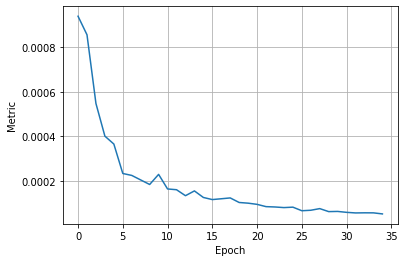

END OF EPOCH 34


100%|██████████| 405/405 [00:42<00:00,  9.44it/s]
102it [00:05, 17.64it/s]


4.7358457603782e-05
[0.00035999999999999997]


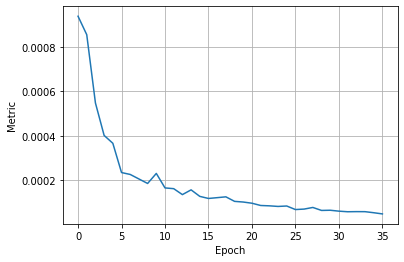

END OF EPOCH 35


100%|██████████| 405/405 [00:43<00:00,  9.29it/s]
102it [00:05, 17.02it/s]


5.238313266708648e-05
[0.00035999999999999997]


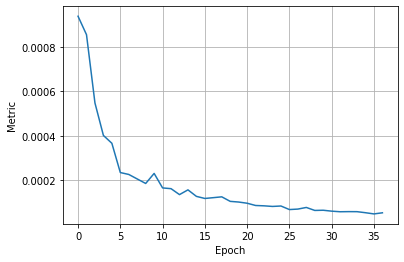

END OF EPOCH 36


100%|██████████| 405/405 [00:43<00:00,  9.36it/s]
102it [00:05, 17.21it/s]


4.9285975472484316e-05
[0.00035999999999999997]


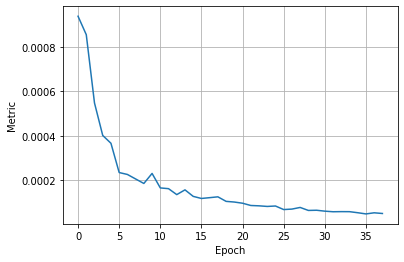

END OF EPOCH 37


100%|██████████| 405/405 [00:43<00:00,  9.36it/s]
102it [00:05, 17.11it/s]


4.5621901257675575e-05
[0.00035999999999999997]


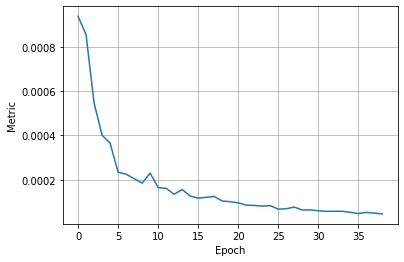

END OF EPOCH 38


100%|██████████| 405/405 [00:43<00:00,  9.28it/s]
102it [00:05, 17.27it/s]


4.3282622605875855e-05
[0.00035999999999999997]


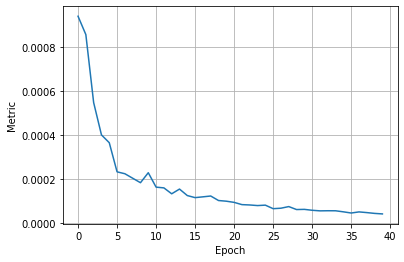

END OF EPOCH 39


100%|██████████| 405/405 [00:43<00:00,  9.28it/s]
102it [00:05, 17.41it/s]


4.099108433472512e-05
[0.00035999999999999997]


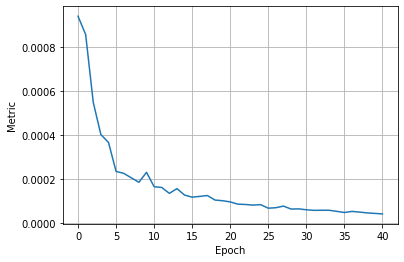

END OF EPOCH 40


100%|██████████| 405/405 [00:43<00:00,  9.39it/s]
102it [00:05, 17.40it/s]


4.55741608770266e-05
[0.00021599999999999996]


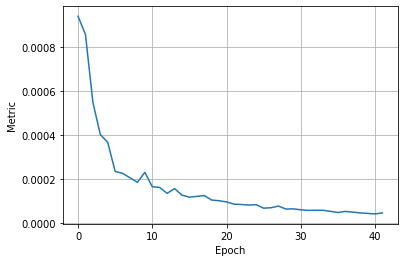

END OF EPOCH 41


100%|██████████| 405/405 [00:43<00:00,  9.33it/s]
102it [00:06, 16.78it/s]


4.3216979582483516e-05
[0.00021599999999999996]


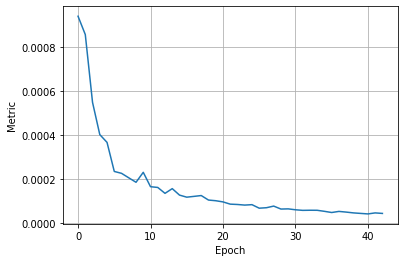

END OF EPOCH 42


  9%|▉         | 37/405 [00:04<00:41,  8.90it/s]


KeyboardInterrupt: ignored

In [ ]:
# TRAIN
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=14, gamma=0.6)

for n in range(TaskConfig_student_3.num_epochs):

    train_epoch_teach_stud(model_stud_3, model, my_loss, opt, train_loader, melspec_train, config_stud.device)

    au_fa_fr = validation(model_stud_3, val_loader,
                          melspec_val, config_stud.device)
    print(au_fa_fr)
    scheduler.step()
    print(scheduler.get_last_lr())
    history['val_metric'].append(au_fa_fr)

    # clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
history

defaultdict(list,
            {'val_metric': [0.0009386087050705207,
              0.0008554897185868667,
              0.000547516523020337,
              0.00040121314274776617,
              0.0003658464720082483,
              0.00023385625460899806,
              0.00022527492118734502,
              0.0002049315514833011,
              0.00018464188970748725,
              0.00022989081924134272,
              0.00016457899473975597,
              0.00016117749261851662,
              0.00013440707416960456,
              0.0001558126673430882,
              0.00012644039814880707,
              0.00011703554316095924,
              0.00012063397435237562,
              0.00012438756178090118,
              0.00010394274376797817,
              0.00010090227827539664,
              9.557027451166438e-05,
              8.537770324310849e-05,
              8.382017332443572e-05,
              8.108703653228198e-05,
              8.300858685340316e-05,
              6.69976566932535

In [ ]:
get_size_in_megabytes(model) / get_size_in_megabytes(model_stud_3) 

9.61285480349345

In [ ]:
get_size_in_megabytes(model_stud_3) 

0.0279541015625

In [ ]:
input = torch.randn(1, 40, 101).to(config.device)

In [ ]:
profile(model_stud_3, inputs=(input, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(149310.0, 7328.0)

In [ ]:
# torch.save(model_stud_3.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/student3_model_3.pt') 

In [ ]:
# torch.save(model_stud_3.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/xz3.pt') 

In [ ]:
# model_stud_4 = CRNN(config_stud3).to(config_stud3.device)
# model_stud_4.load_state_dict(torch.load('/gdrive/MyDrive/AUDIO_DLA/hm_2kws/prod/xz3.pt'))

<All keys matched successfully>

### Load model

In [58]:
!gdown --id  1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6

Downloading...
From: https://drive.google.com/uc?id=1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6
To: /content/xz3.pt
100% 32.9k/32.9k [00:00<00:00, 28.0MB/s]


In [59]:
PATH_base3 = '/content/xz3.pt'

In [60]:
model_stud_3 = CRNN(config_stud3).to(config_stud3.device)
model_stud_3.load_state_dict(torch.load('/content/xz3.pt'))

<All keys matched successfully>

In [62]:
validation(model_stud_3, val_loader, melspec_val, config_stud3.device)

102it [00:07, 14.53it/s]


4.092544131133278e-05

# TRY 4 quantiz qint8

In [ ]:
class TaskConfig_student_4:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 5
    kernel_size: Tuple[int, int] = (12, 20)
    stride: Tuple[int, int] = (5, 8)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device('cpu')

In [ ]:
config_stud4 = TaskConfig_student_4()

In [ ]:
!gdown --id  1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6

Downloading...
From: https://drive.google.com/uc?id=1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6
To: /content/xz3.pt
100% 32.9k/32.9k [00:00<00:00, 28.7MB/s]


In [ ]:
PATH_base3 = '/content/xz3.pt'

In [ ]:
model_stud_4 = CRNN(config_stud4).to(config_stud4.device)
model_stud_4.load_state_dict(torch.load(PATH_base3))

<All keys matched successfully>

In [ ]:
torch.backends.quantized.engine = 'qnnpack'

In [ ]:
model_int8 = torch.quantization.quantize_dynamic(
    model_stud_4,  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU}, # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [ ]:
melspec_val_cpu = LogMelspec(is_train=False, config=config_stud4)

In [ ]:
validation(model_int8, val_loader, melspec_val_cpu, config_stud4.device)

102it [00:08, 11.34it/s]


4.10686624532797e-05

In [ ]:
profile(model_int8, inputs=(torch.randn(1, 40, 20).to("cpu"), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

(7230.0, 1205.0)

In [ ]:
torch.save(model_int8.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/model_int8.pt') 

In [ ]:
get_size_in_megabytes(model_int8)

0.004596710205078125

In [ ]:
!pip install torchsummary

from torchsummary import summary
summary(model_int8, input_size=(40, 100), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 5, 6, 11]           1,205
           Flatten-2               [-1, 30, 11]               0
               GRU-3  [[-1, 11, 20], [-1, 2, 20]]               0
            Linear-4               [-1, 11, 20]               0
              Tanh-5               [-1, 11, 20]               0
            Linear-6                [-1, 11, 1]               0
         Attention-7                   [-1, 20]               0
            Linear-8                    [-1, 2]               0
Total params: 1,205
Trainable params: 1,205
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.06
Params size (MB): 0.00
Estimated Total Size (MB): 0.08
----------------------------------------------------------------


### Load model

In [ ]:
!gdown --id  1--umhon8pVDLzBqe_ryUuc0pa1zgnE2j

Downloading...
From: https://drive.google.com/uc?id=1--umhon8pVDLzBqe_ryUuc0pa1zgnE2j
To: /content/model_int8.pt
100% 20.7k/20.7k [00:00<00:00, 33.5MB/s]


In [ ]:
PATH_base4 = '/content/model_int8.pt'

In [ ]:
model_int8 = CRNN(config_stud4).to(config_stud4.device)
model_int8 = torch.quantization.quantize_dynamic(
    model_int8,  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU}, # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights
model_int8.load_state_dict(torch.load(PATH_base4))

<All keys matched successfully>

In [ ]:
melspec_val_cpu = LogMelspec(is_train=False, config=config_stud4)

In [ ]:
validation(model_int8, val_loader, melspec_val_cpu, config_stud4.device)

102it [00:08, 11.54it/s]


4.10686624532797e-05

# TRY 5 quantiz float16

In [ ]:
class TaskConfig_student_5:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 5
    kernel_size: Tuple[int, int] = (12, 20)
    stride: Tuple[int, int] = (5, 8)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device('cpu')

In [ ]:
config_stud5 = TaskConfig_student_5()

In [ ]:
!gdown --id  1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6

Downloading...
From: https://drive.google.com/uc?id=1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6
To: /content/xz3.pt
100% 32.9k/32.9k [00:00<00:00, 29.2MB/s]


In [ ]:
PATH_base3 = '/content/xz3.pt'

In [ ]:
model_stud_5 = CRNN(config_stud5).to(config_stud5.device)
model_stud_5.load_state_dict(torch.load(PATH_base3))

<All keys matched successfully>

In [ ]:
torch.backends.quantized.engine = 'fbgemm'


In [ ]:
model_float16 = torch.quantization.quantize_dynamic(
    model_stud_5,  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU}, # a set of layers to dynamically quantize
    dtype=torch.float16)  # the target dtype for quantized weights

In [ ]:
validation(model_float16, val_loader, melspec_val_cpu, config_stud5.device)

102it [00:09, 11.20it/s]


4.091947376375165e-05

In [ ]:
torch.save(model_float16.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/model_float16.pt') 

In [ ]:
get_size_in_megabytes(model_float16)

0.004596710205078125

In [ ]:
get_size_in_megabytes(model_int8)

0.004596710205078125

### Load model

In [ ]:
!gdown --id  1Hs4mfQ16O-fkj9sQvFDjuxzuZDCrdDF0

Downloading...
From: https://drive.google.com/uc?id=1Hs4mfQ16O-fkj9sQvFDjuxzuZDCrdDF0
To: /content/model_float16.pt
100% 36.2k/36.2k [00:00<00:00, 29.0MB/s]


In [ ]:
PATH_base4 = '/content/model_float16.pt'

In [ ]:
model_float16 = CRNN(config_stud4).to(config_stud4.device)
model_float16 = torch.quantization.quantize_dynamic(
    model_float16,  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU}, # a set of layers to dynamically quantize
    dtype=torch.float16)  # the target dtype for quantized weights
model_float16.load_state_dict(torch.load(PATH_base4))

<All keys matched successfully>

In [ ]:
melspec_val_cpu = LogMelspec(is_train=False, config=config_stud4)

In [ ]:
validation(model_float16, val_loader, melspec_val_cpu, config_stud4.device)

102it [00:09, 11.13it/s]


4.091947376375165e-05

# Try 6 pruning

Pruning multiple parameters in a model

In [ ]:
class TaskConfig_student_6:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 1e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 5
    kernel_size: Tuple[int, int] = (12, 20)
    stride: Tuple[int, int] = (5, 8)
    hidden_size: int = 20
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')
config_stud6 = TaskConfig_student_6()

In [ ]:
!gdown --id  1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6

Downloading...
From: https://drive.google.com/uc?id=1-7mqabzEVYS5xWGxxbtoL3LW3gCuX9T6
To: /content/xz3.pt
100% 32.9k/32.9k [00:00<00:00, 62.8MB/s]


In [ ]:
PATH_base3 = '/content/xz3.pt'

In [ ]:
model_stud_6 = CRNN(config_stud6).to(config_stud6.device)
model_stud_6.load_state_dict(torch.load(PATH_base3))

<All keys matched successfully>

In [ ]:
# model_stud_6 = CRNN(config_stud6).to(config_stud6.device)
# model_stud_6.load_state_dict(torch.load('/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/xz3.pt'))

In [ ]:
import torch.nn.utils.prune as prune

In [ ]:
for name, module in model_stud_6.named_modules():
    if isinstance(module, torch.nn.Conv2d):
        prune.ln_structured(module, name="weight", amount=0.2, n=2, dim=0)
    elif isinstance(module, torch.nn.Linear):
        prune.ln_structured(module, name="weight", amount=0.2, n=2, dim=0)

print(dict(model_stud_6.named_buffers()).keys())  # to verify that all masks exist

dict_keys(['conv.0.weight_mask', 'attention.energy.0.weight_mask', 'attention.energy.2.weight_mask', 'classifier.weight_mask'])


In [ ]:
profile(model_stud_6, inputs=(torch.randn(1, 40, 100).to("cuda:0"), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(149310.0, 7328.0)

In [ ]:
prune.ln_structured(module, name="weight", amount=0.5, n=2, dim=0)


Linear(in_features=20, out_features=2, bias=True)

In [ ]:
for name in model_stud_6.parameters():
    print(name.data)

In [ ]:
validation(model_stud_6, val_loader, melspec_val, config.device)

102it [00:05, 19.18it/s]


5.2162333406584973e-05

In [ ]:
get_size_in_megabytes(model_stud_6)

0.0279541015625

In [ ]:
# torch.save(model_stud_6.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/model_stud_6_prooning.pt') 

# TRY 7✈

In [63]:
class TaskConfig_student_7:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 6e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 3
    kernel_size: Tuple[int, int] = (10, 20)
    stride: Tuple[int, int] = (4, 8)
    hidden_size: int = 18
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device(
        'cuda:0' if torch.cuda.is_available() else 'cpu')

In [64]:
config_stud7 = TaskConfig_student_7()
model_stud_7 = CRNN(config_stud7).to(config_stud7.device)

In [65]:
input.shape

torch.Size([1, 40, 100])

In [66]:
profile(model_stud_7, inputs=(input, ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[INFO] Register count_gru() for <class 'torch.nn.modules.rnn.GRU'>.
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.Attention'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class '__main__.CRNN'>. Treat it as zero Macs and zero Params.


(108342.0, 5430.0)

In [ ]:
opt = torch.optim.Adam(
    model_stud_7.parameters(),
    lr=config_stud7.learning_rate,
    weight_decay=config_stud7.weight_decay
)
history = defaultdict(list)

100%|██████████| 405/405 [00:41<00:00,  9.66it/s]
102it [00:05, 18.23it/s]


0.0008357699576050501
[0.001]


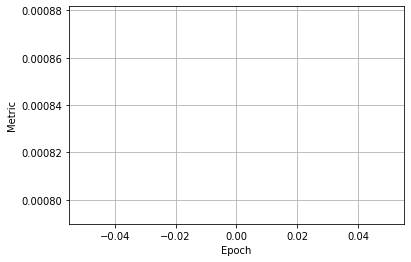

END OF EPOCH 0


100%|██████████| 405/405 [00:41<00:00,  9.65it/s]
102it [00:05, 18.03it/s]


0.000638706617607458
[0.001]


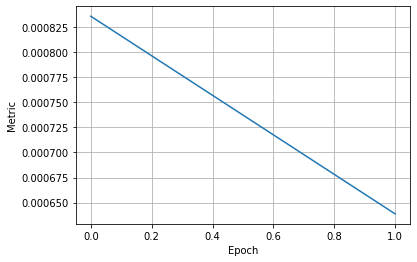

END OF EPOCH 1


100%|██████████| 405/405 [00:41<00:00,  9.66it/s]
102it [00:05, 17.99it/s]


0.000524917420330629
[0.001]


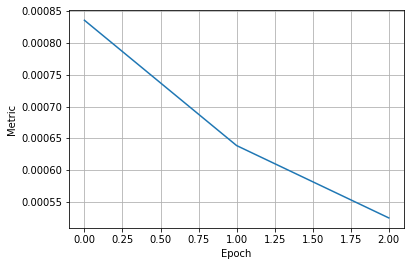

END OF EPOCH 2


100%|██████████| 405/405 [00:42<00:00,  9.63it/s]
102it [00:05, 17.87it/s]


0.0004270943966070911
[0.001]


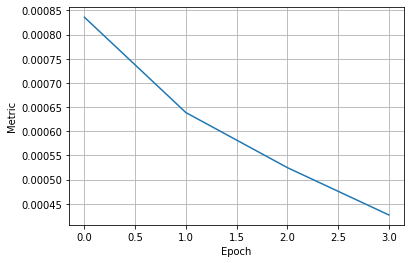

END OF EPOCH 3


100%|██████████| 405/405 [00:42<00:00,  9.54it/s]
102it [00:05, 17.97it/s]


0.0003163546161442154
[0.001]


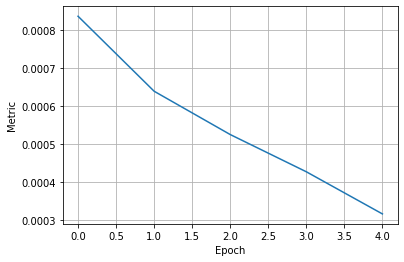

END OF EPOCH 4


100%|██████████| 405/405 [00:42<00:00,  9.54it/s]
102it [00:05, 17.83it/s]


0.00030463733646868285
[0.001]


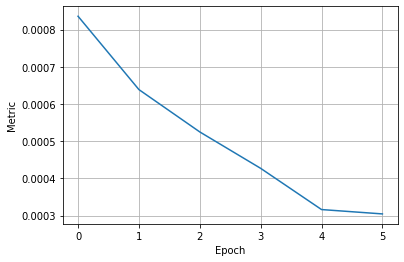

END OF EPOCH 5


100%|██████████| 405/405 [00:42<00:00,  9.64it/s]
102it [00:05, 17.94it/s]


0.00024052797280469217
[0.001]


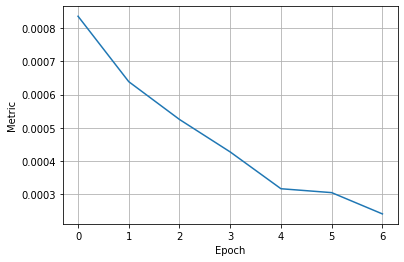

END OF EPOCH 6


100%|██████████| 405/405 [00:42<00:00,  9.59it/s]
102it [00:05, 17.58it/s]


0.0002071693818262217
[0.001]


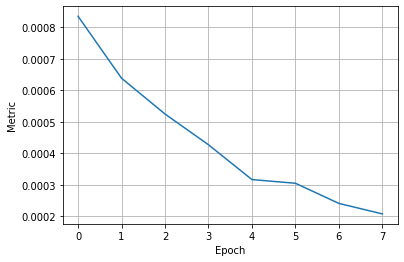

END OF EPOCH 7


100%|██████████| 405/405 [00:41<00:00,  9.67it/s]
102it [00:05, 17.74it/s]


0.00019327693105737037
[0.001]


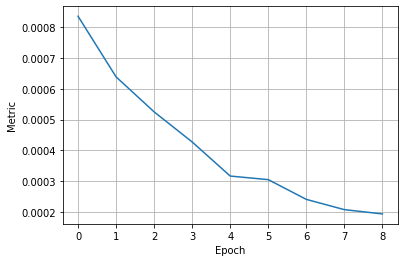

END OF EPOCH 8


100%|██████████| 405/405 [00:42<00:00,  9.63it/s]
102it [00:05, 18.27it/s]


0.00017156400918345895
[0.001]


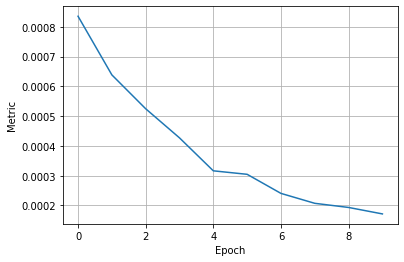

END OF EPOCH 9


100%|██████████| 405/405 [00:42<00:00,  9.62it/s]
102it [00:05, 17.64it/s]


0.00014977649296478356
[0.001]


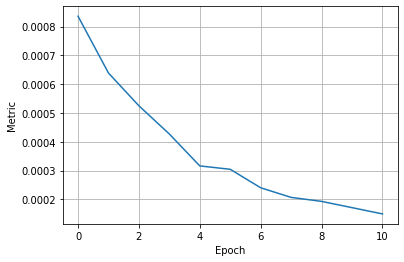

END OF EPOCH 10


100%|██████████| 405/405 [00:42<00:00,  9.57it/s]
102it [00:05, 17.93it/s]


0.00011708925108918932
[0.001]


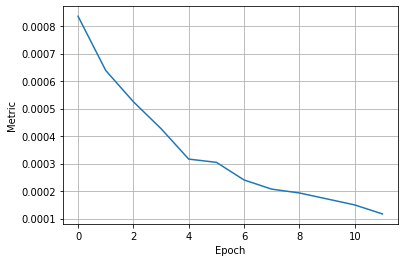

END OF EPOCH 11


100%|██████████| 405/405 [00:42<00:00,  9.58it/s]
102it [00:05, 17.52it/s]


0.00013093097770360115
[0.001]


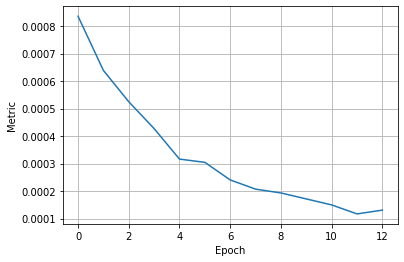

END OF EPOCH 12


100%|██████████| 405/405 [00:42<00:00,  9.52it/s]
102it [00:05, 17.71it/s]


9.762311087957027e-05
[0.0006]


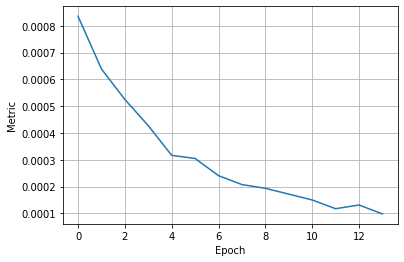

END OF EPOCH 13


100%|██████████| 405/405 [00:42<00:00,  9.61it/s]
102it [00:05, 17.80it/s]


0.00010181232928151772
[0.0006]


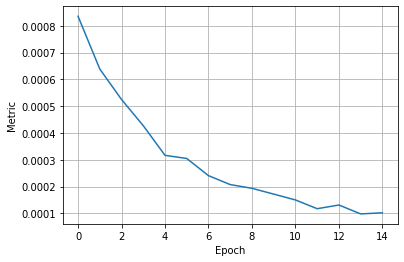

END OF EPOCH 14


100%|██████████| 405/405 [00:42<00:00,  9.53it/s]
102it [00:05, 17.94it/s]


9.345477889415674e-05
[0.0006]


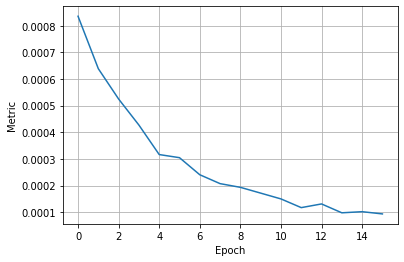

END OF EPOCH 15


100%|██████████| 405/405 [00:42<00:00,  9.47it/s]
102it [00:05, 17.69it/s]


0.00010014141595880363
[0.0006]


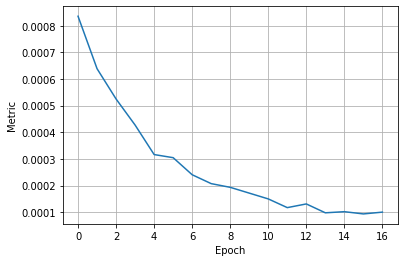

END OF EPOCH 16


100%|██████████| 405/405 [00:42<00:00,  9.56it/s]
102it [00:05, 17.45it/s]


8.652645615247443e-05
[0.0006]


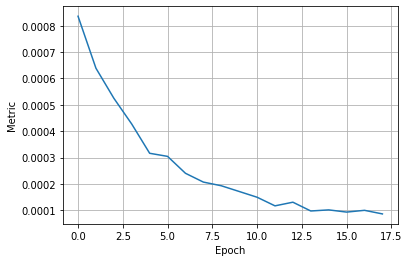

END OF EPOCH 17


100%|██████████| 405/405 [00:42<00:00,  9.58it/s]
102it [00:05, 17.49it/s]


9.181967085692938e-05
[0.0006]


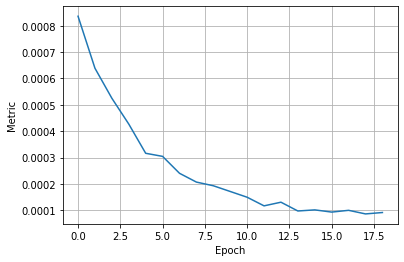

END OF EPOCH 18


100%|██████████| 405/405 [00:42<00:00,  9.60it/s]
102it [00:05, 17.45it/s]


8.33338181965743e-05
[0.0006]


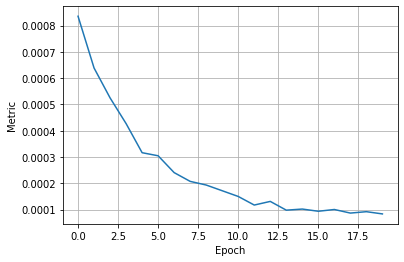

END OF EPOCH 19


100%|██████████| 405/405 [00:42<00:00,  9.49it/s]
102it [00:05, 17.18it/s]


8.06961621657185e-05
[0.0006]


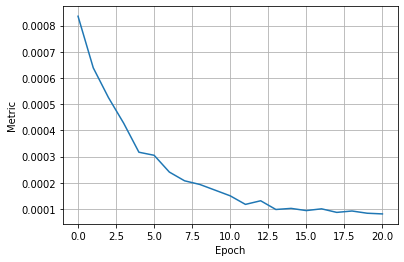

END OF EPOCH 20


100%|██████████| 405/405 [00:42<00:00,  9.52it/s]
102it [00:05, 17.52it/s]


7.801374952800428e-05
[0.0006]


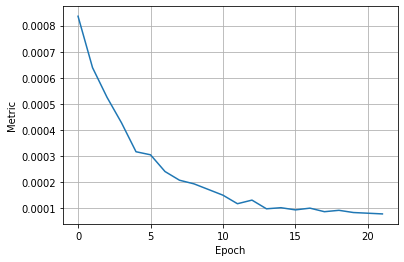

END OF EPOCH 21


100%|██████████| 405/405 [00:42<00:00,  9.55it/s]
102it [00:05, 17.53it/s]


7.989949456363876e-05
[0.0006]


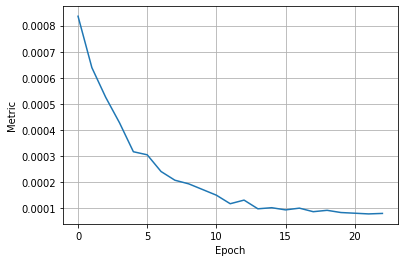

END OF EPOCH 22


100%|██████████| 405/405 [00:42<00:00,  9.52it/s]
102it [00:05, 17.50it/s]


7.012465162576136e-05
[0.0006]


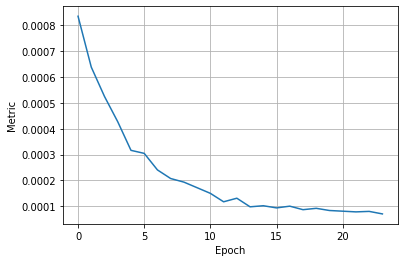

END OF EPOCH 23


100%|██████████| 405/405 [00:42<00:00,  9.56it/s]
102it [00:05, 17.57it/s]


6.477176144549519e-05
[0.0006]


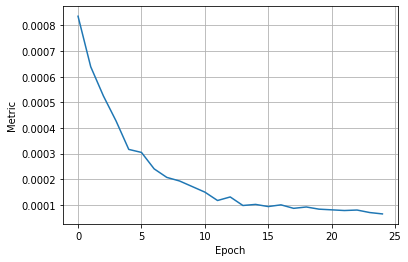

END OF EPOCH 24


100%|██████████| 405/405 [00:42<00:00,  9.50it/s]
102it [00:05, 17.69it/s]


6.855518661192635e-05
[0.0006]


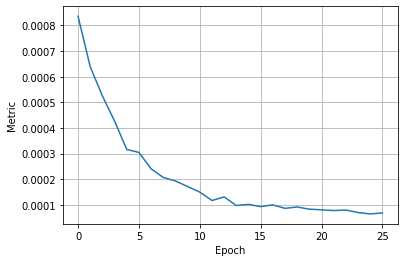

END OF EPOCH 25


100%|██████████| 405/405 [00:42<00:00,  9.54it/s]
102it [00:05, 17.60it/s]


7.602655618349076e-05
[0.0006]


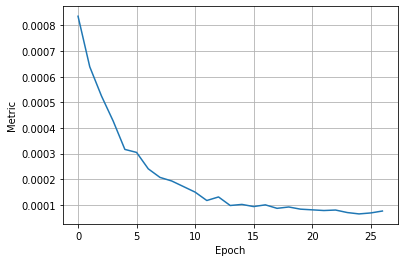

END OF EPOCH 26


100%|██████████| 405/405 [00:42<00:00,  9.54it/s]
102it [00:05, 17.47it/s]


7.454063683579145e-05
[0.00035999999999999997]


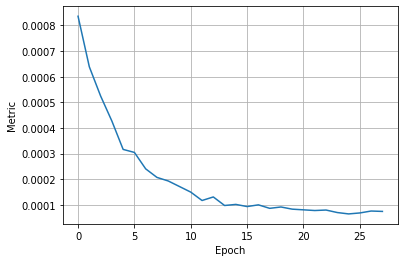

END OF EPOCH 27


100%|██████████| 405/405 [00:42<00:00,  9.45it/s]
102it [00:05, 17.64it/s]


7.309649032115998e-05
[0.00035999999999999997]


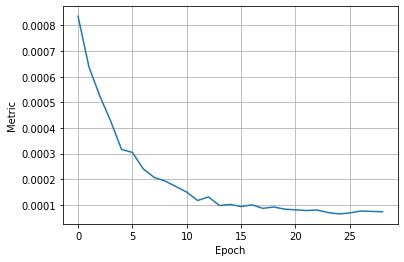

END OF EPOCH 28


100%|██████████| 405/405 [00:42<00:00,  9.53it/s]
102it [00:05, 17.24it/s]


6.12628434677956e-05
[0.00035999999999999997]


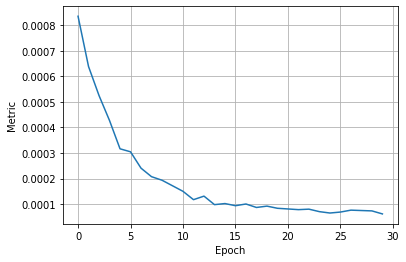

END OF EPOCH 29


100%|██████████| 405/405 [00:42<00:00,  9.46it/s]
102it [00:05, 17.61it/s]


5.608897971496307e-05
[0.00035999999999999997]


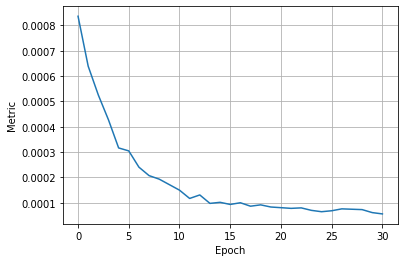

END OF EPOCH 30


100%|██████████| 405/405 [00:42<00:00,  9.54it/s]
102it [00:05, 17.48it/s]


6.48314369213064e-05
[0.00035999999999999997]


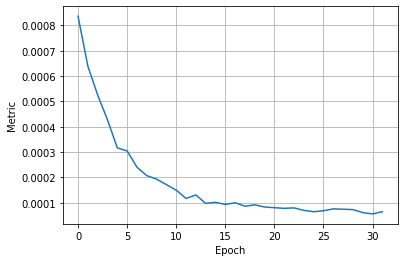

END OF EPOCH 31


100%|██████████| 405/405 [00:42<00:00,  9.43it/s]
102it [00:05, 17.46it/s]


6.219974843803172e-05
[0.00035999999999999997]


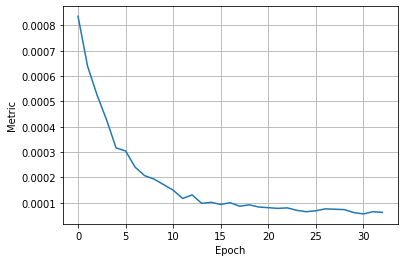

END OF EPOCH 32


100%|██████████| 405/405 [00:42<00:00,  9.49it/s]
102it [00:05, 17.11it/s]


6.0582543043547735e-05
[0.00035999999999999997]


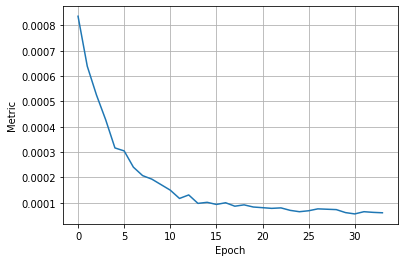

END OF EPOCH 33


100%|██████████| 405/405 [00:42<00:00,  9.46it/s]
102it [00:05, 17.60it/s]


5.96545893946833e-05
[0.00035999999999999997]


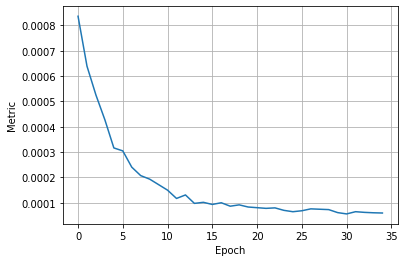

END OF EPOCH 34


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.66it/s]


5.314697875747006e-05
[0.00035999999999999997]


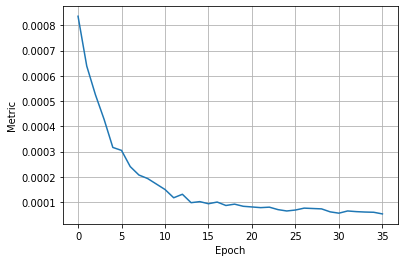

END OF EPOCH 35


100%|██████████| 405/405 [00:43<00:00,  9.42it/s]
102it [00:05, 17.13it/s]


5.626800614239672e-05
[0.00035999999999999997]


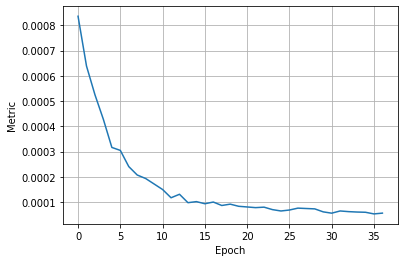

END OF EPOCH 36


100%|██████████| 405/405 [00:42<00:00,  9.47it/s]
102it [00:05, 17.67it/s]


5.1786377908974305e-05
[0.00035999999999999997]


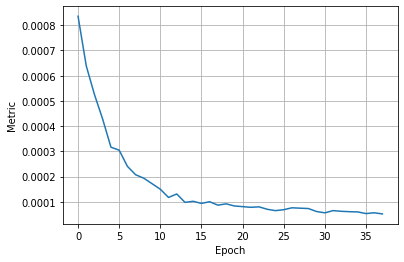

END OF EPOCH 37


100%|██████████| 405/405 [00:42<00:00,  9.44it/s]
102it [00:05, 17.36it/s]


5.240700285741097e-05
[0.00035999999999999997]


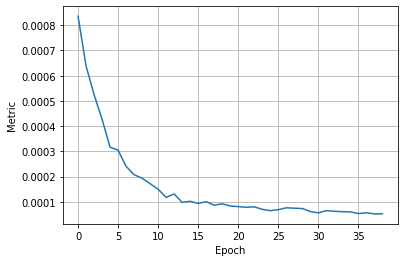

END OF EPOCH 38


100%|██████████| 405/405 [00:42<00:00,  9.50it/s]
102it [00:05, 17.38it/s]


5.2508451166290037e-05
[0.00035999999999999997]


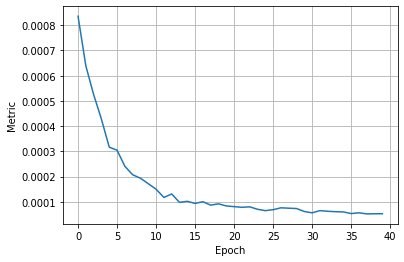

END OF EPOCH 39


100%|██████████| 405/405 [00:42<00:00,  9.42it/s]
102it [00:05, 17.14it/s]


5.4817892080184144e-05
[0.00035999999999999997]


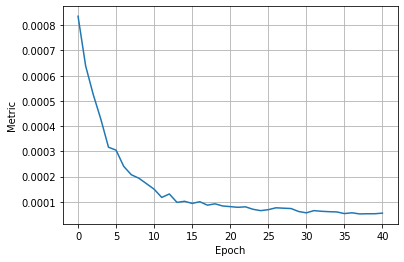

END OF EPOCH 40


100%|██████████| 405/405 [00:42<00:00,  9.42it/s]
102it [00:05, 17.13it/s]


5.434048827369441e-05
[0.00021599999999999996]


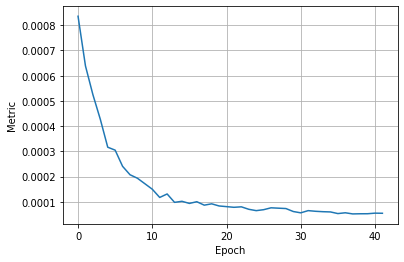

END OF EPOCH 41


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.30it/s]


5.381236031276513e-05
[0.00021599999999999996]


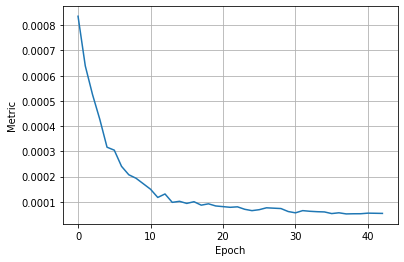

END OF EPOCH 42


100%|██████████| 405/405 [00:43<00:00,  9.31it/s]
102it [00:05, 17.16it/s]


5.345132368410727e-05
[0.00021599999999999996]


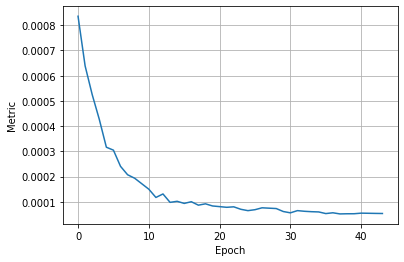

END OF EPOCH 43


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:05, 17.23it/s]


4.988273023059648e-05
[0.00021599999999999996]


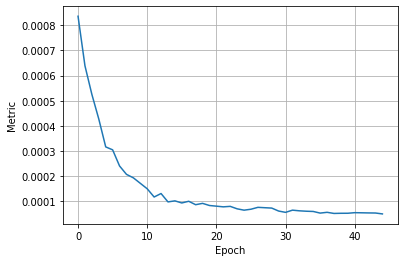

END OF EPOCH 44


100%|██████████| 405/405 [00:43<00:00,  9.41it/s]
102it [00:06, 16.98it/s]


5.040190687015407e-05
[0.00021599999999999996]


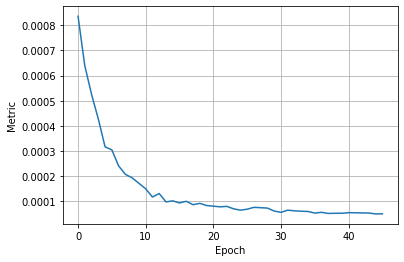

END OF EPOCH 45


100%|██████████| 405/405 [00:43<00:00,  9.25it/s]
102it [00:05, 17.13it/s]


5.4412098844667863e-05
[0.00021599999999999996]


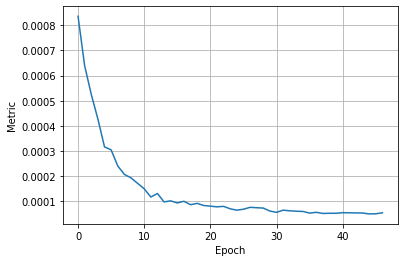

END OF EPOCH 46


100%|██████████| 405/405 [00:43<00:00,  9.37it/s]
102it [00:05, 17.45it/s]


4.5836732970595954e-05
[0.00021599999999999996]


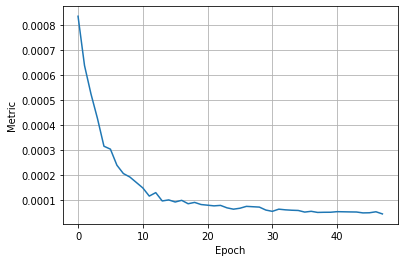

END OF EPOCH 47


100%|██████████| 405/405 [00:42<00:00,  9.44it/s]
102it [00:05, 17.30it/s]


5.2920211949387445e-05
[0.00021599999999999996]


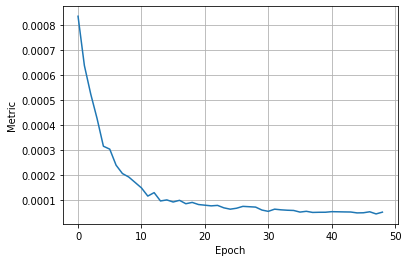

END OF EPOCH 48


100%|██████████| 405/405 [00:42<00:00,  9.42it/s]
102it [00:05, 17.43it/s]


4.634994206257243e-05
[0.00021599999999999996]


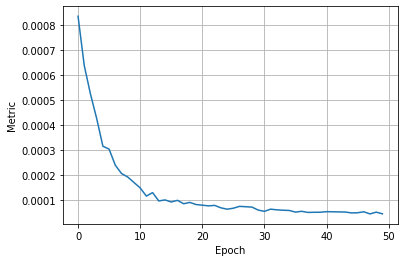

END OF EPOCH 49


100%|██████████| 405/405 [00:43<00:00,  9.36it/s]
102it [00:06, 16.83it/s]


5.4996918507617804e-05
[0.00021599999999999996]


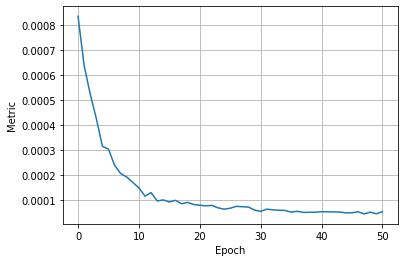

END OF EPOCH 50


100%|██████████| 405/405 [00:43<00:00,  9.27it/s]
102it [00:05, 17.08it/s]


4.80208553852865e-05
[0.00021599999999999996]


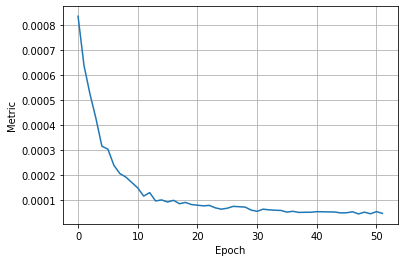

END OF EPOCH 51


100%|██████████| 405/405 [00:43<00:00,  9.27it/s]
102it [00:06, 16.71it/s]


4.799101764738089e-05
[0.00021599999999999996]


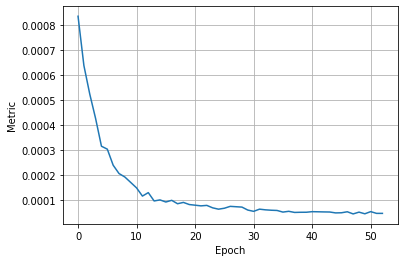

END OF EPOCH 52


100%|██████████| 405/405 [00:43<00:00,  9.29it/s]
102it [00:06, 16.82it/s]


4.5156432546348083e-05
[0.00021599999999999996]


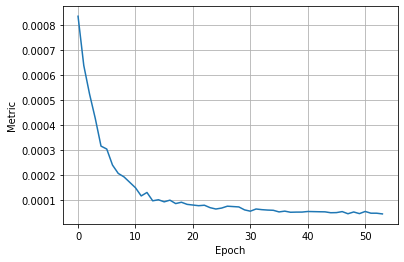

END OF EPOCH 53


 46%|████▌     | 187/405 [00:20<00:24,  9.01it/s]


KeyboardInterrupt: ignored

In [ ]:
# TRAIN
scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=14, gamma=0.6)

for n in range(TaskConfig_student_3.num_epochs):

    train_epoch_teach_stud(model_stud_7, model, my_loss, opt, train_loader, melspec_train, config_stud.device)

    au_fa_fr = validation(model_stud_7, val_loader,
                          melspec_val, config_stud.device)
    print(au_fa_fr)
    scheduler.step()
    print(scheduler.get_last_lr())
    history['val_metric'].append(au_fa_fr)

    # clear_output()
    plt.plot(history['val_metric'])
    plt.ylabel('Metric')
    plt.xlabel('Epoch')
    plt.grid()
    plt.show()

    print('END OF EPOCH', n)

In [ ]:
torch.save(model_stud_7.state_dict(),'/content/drive/MyDrive/AUDIO_DLA/hm_2kws/prod/student7_model_stud_7.pt') 

In [ ]:
validation(model_stud_7, val_loader, melspec_val, config_stud7.device)

102it [00:05, 18.76it/s]


0.011607106812089835

### Load model

In [67]:
!gdown --id  1-GM0wkR9CH6lLgRzS9R-UT4SFYKXzch9

Downloading...
From: https://drive.google.com/uc?id=1-GM0wkR9CH6lLgRzS9R-UT4SFYKXzch9
To: /content/student7_model_stud_7.pt
100% 28.7k/28.7k [00:00<00:00, 51.4MB/s]


In [68]:
PATH_base7 = "/content/student7_model_stud_7.pt"

In [69]:
model_stud_7 = CRNN(config_stud7).to(config_stud7.device)
model_stud_7.load_state_dict(torch.load(PATH_base7))

RuntimeError: ignored

Если выше будет ошибка RuntimeError: Error(s) in loading state_dict for CRNN, то ничего страшного, можете запускать ячейку ниже

In [70]:
validation(model_stud_7, val_loader, melspec_val, config_stud7.device)

102it [00:07, 14.37it/s]


4.411211171965177e-05

# TRY 8 quantiz qint8, final?🤡🤡

In [71]:
class TaskConfig_student_8:
    keyword: str = 'sheila'  # We will use 1 key word -- 'sheila'
    batch_size: int = 128
    learning_rate: float = 1e-3
    weight_decay: float = 6e-5
    num_epochs: int = 100
    n_mels: int = 40
    cnn_out_channels: int = 3
    kernel_size: Tuple[int, int] = (10, 20)
    stride: Tuple[int, int] = (4, 8)
    hidden_size: int = 18
    gru_num_layers: int = 2
    bidirectional: bool = False
    num_classes: int = 2
    sample_rate: int = 16000
    device: torch.device = torch.device('cpu')

In [72]:
config_stud8 = TaskConfig_student_8()

In [73]:
!gdown --id  1-GM0wkR9CH6lLgRzS9R-UT4SFYKXzch9

Downloading...
From: https://drive.google.com/uc?id=1-GM0wkR9CH6lLgRzS9R-UT4SFYKXzch9
To: /content/student7_model_stud_7.pt
100% 28.7k/28.7k [00:00<00:00, 41.9MB/s]


In [74]:
PATH_base7 = "/content/student7_model_stud_7.pt"

In [75]:
model_stud_8 = CRNN(config_stud8).to(config_stud8.device)
model_stud_8.load_state_dict(torch.load(PATH_base7))

RuntimeError: ignored

In [76]:
torch.backends.quantized.engine = 'qnnpack'

In [77]:
model_stud_8 = torch.quantization.quantize_dynamic(
    model_stud_8,  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU}, # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights

In [78]:
melspec_val_cpu = LogMelspec(is_train=False, config=config_stud8)

In [79]:
validation(model_stud_8, val_loader, melspec_val_cpu, config_stud8.device)

102it [00:11,  8.76it/s]


4.5603998614932205e-05

In [ ]:
profile(model_stud_8, inputs=(torch.randn(1, 40, 20).to("cpu"), ))

[INFO] Register count_convNd() for <class 'torch.nn.modules.conv.Conv2d'>.
[WARN] Cannot find rule for <class 'torch.nn.modules.flatten.Flatten'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.Sequential'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.PackedParameter'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.container.ModuleList'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.rnn.GRU'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.modules.linear.LinearPackedParams'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.quantized.dynamic.modules.linear.Linear'>. Treat it as zero Macs and zero Params.
[WARN] Cannot find rule for <class 'torch.nn.modules.activation.Tanh'>

(4824.0, 603.0)

In [ ]:
torch.save(model_stud_8.state_dict(),'/gdrive/MyDrive/AUDIO_DLA/hm_2kws/prod/model_studwith_qint8.pt') 

In [ ]:
get_size_in_megabytes(model_stud_8)

0.002300262451171875

In [ ]:
!pip install torchsummary

from torchsummary import summary
summary(model_stud_8, input_size=(40, 100), device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1             [-1, 3, 8, 11]             603
           Flatten-2               [-1, 24, 11]               0
               GRU-3  [[-1, 11, 18], [-1, 2, 18]]               0
            Linear-4               [-1, 11, 18]               0
              Tanh-5               [-1, 11, 18]               0
            Linear-6                [-1, 11, 1]               0
         Attention-7                   [-1, 18]               0
            Linear-8                    [-1, 2]               0
Total params: 603
Trainable params: 603
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 0.05
Params size (MB): 0.00
Estimated Total Size (MB): 0.06
----------------------------------------------------------------


### Load model

In [ ]:
!gdown --id  1GcH0Pzkhw2GpzXJyR7CbcSImin83-Dp7

Downloading...
From: https://drive.google.com/uc?id=1GcH0Pzkhw2GpzXJyR7CbcSImin83-Dp7
To: /content/model_studwith_qint8.pt
100% 26.7k/26.7k [00:00<00:00, 21.4MB/s]


In [ ]:
PATH_base4 = '/content/model_studwith_qint8.pt'

In [ ]:
model_stud_8 = CRNN(config_stud8).to(config_stud8.device)
model_stud_8 = torch.quantization.quantize_dynamic(
    model_stud_8,  # the original model
    {nn.Linear, nn.Conv2d, nn.GRU}, # a set of layers to dynamically quantize
    dtype=torch.qint8)  # the target dtype for quantized weights
model_stud_8.load_state_dict(torch.load(PATH_base4))

RuntimeError: ignored

Если выше ощибка RuntimeError: Error(s) in loading state_dict for CRNN:, то все норм

In [ ]:
melspec_val_cpu = LogMelspec(is_train=False, config=config_stud8)

In [ ]:
validation(model_stud_8, val_loader, melspec_val_cpu, config_stud8.device)

102it [00:09, 10.73it/s]


4.5603998614932205e-05

# Results ✅✅✅

Скорость рамерена на входных наддных размера input.shape = torch.Size([1, 40, 100])


In [ ]:
y = [2.515918060200918e-05, 3.587092851012268e-05, 4.092544131133278e-05, 4.10686624532797e-05, 4.091947376375165e-05, 4.886227959422466e-05, 4.411211171965177e-05, 4.5603998614932205e-05]
x_speed = [933808,658400,149310, 149310, 149310,149310, 108342.0, 108342.0]
x = [279, 91, 35, 20, 35, 43 , 28, 26 ]
n = ["base model", "Model Try 1:low Distilation","Model Try 3:Distilation", "Model Try 4(3): Distilation + qint8", "Model Try 5(3): Distilation + float16", "Model Try 6(3): Distilation + structured prooning", "Model try 7: Hard distilation", "Model try 8(7): Hard distilation + quantization qint8"]

In [ ]:
import seaborn as sns
df_image = pd.DataFrame({
'x': x,
'y': y,
'x_speed': x_speed,
'group': n,
"names": n
})

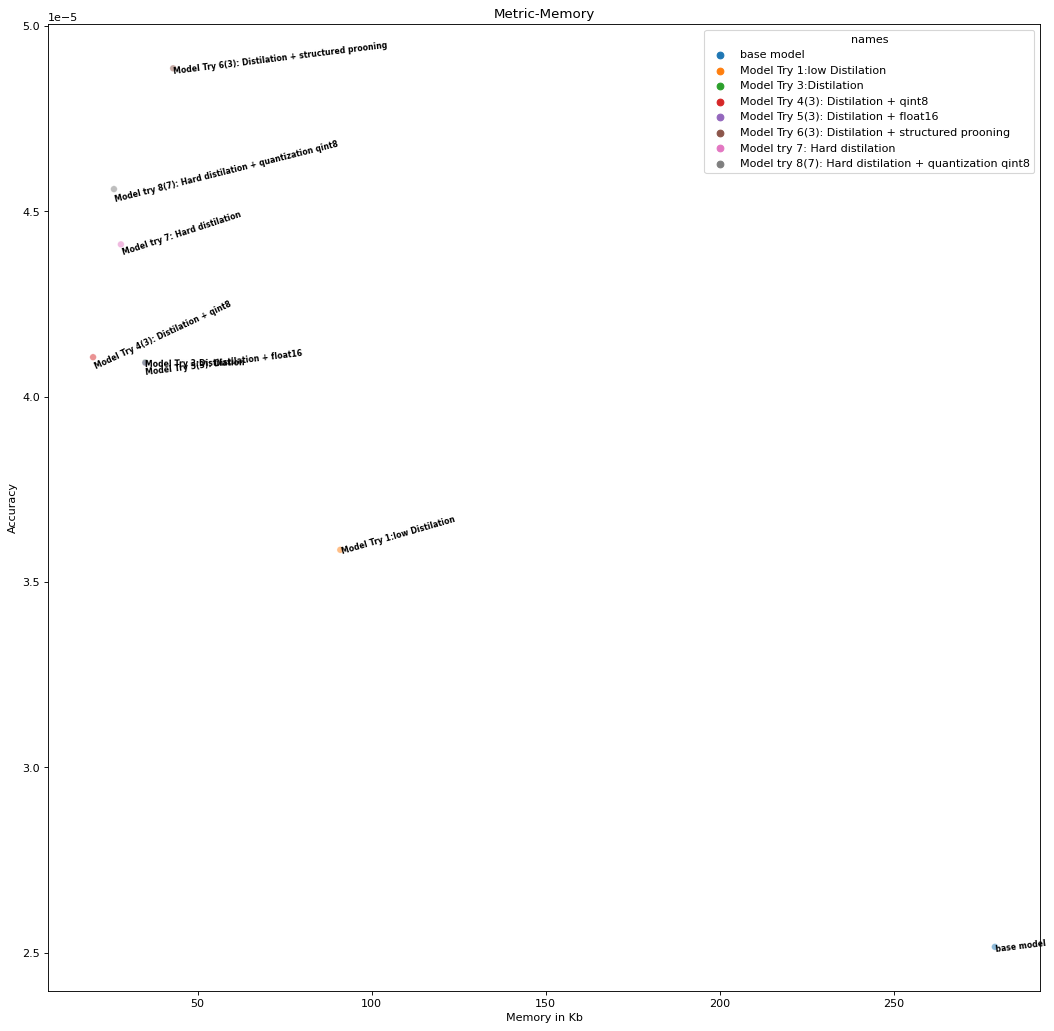

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(16, 16), dpi=80)
sns.scatterplot(data=df_image, x="x", y="y", hue="names", color="skyblue", alpha=.5)
plt.title("Metric-Memory")
plt.xlabel("Memory in Kb")
plt.ylabel("Accuracy")

for line in range(0,df_image.shape[0]):
     plt.text(df_image.x[line], df_image.y[line]+random.uniform(-0.0000005,0), df_image.group[line], rotation=random.randint(0,30), size='x-small', color='black', weight='semibold')


В названии в скобках указана родительская предобученная модель, веса которого использовались

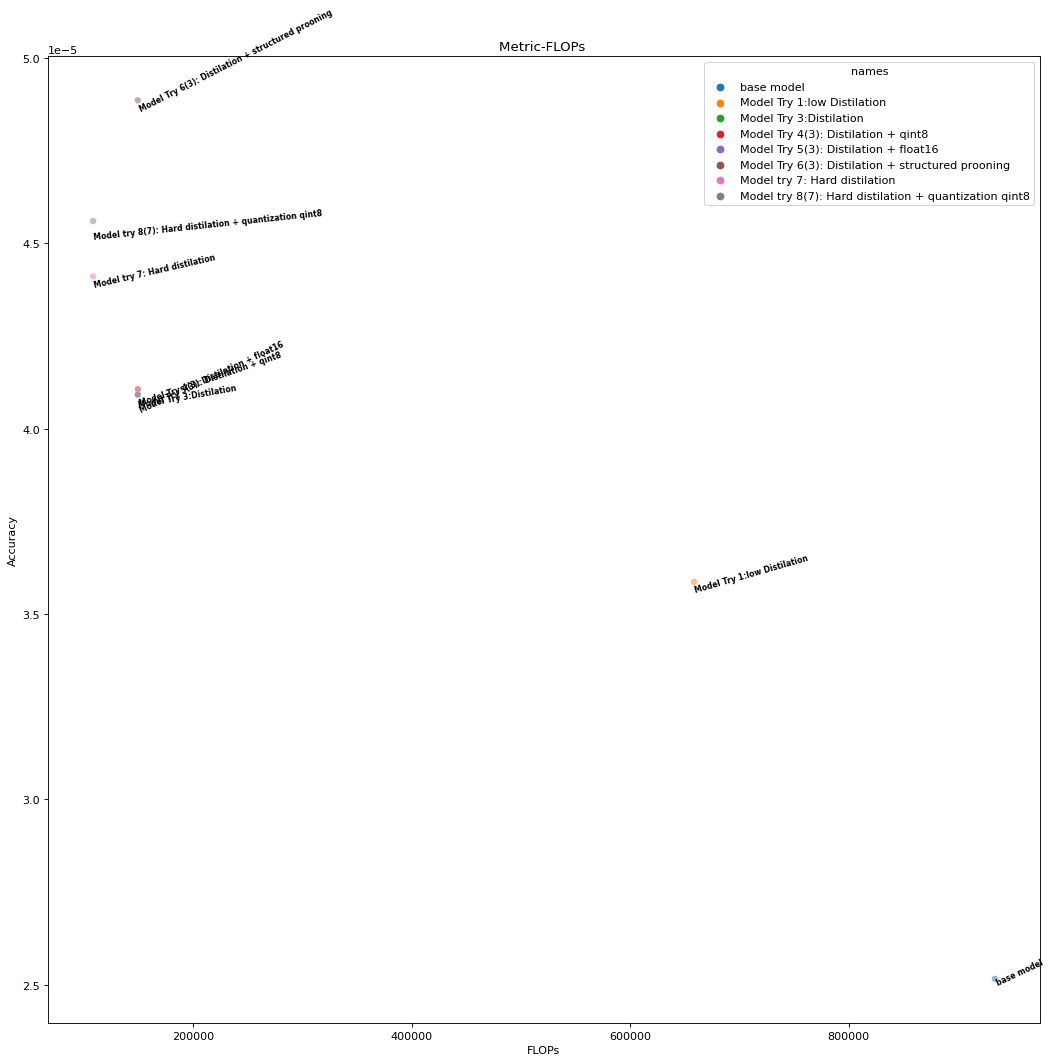

In [ ]:
from matplotlib.pyplot import figure

figure(figsize=(16, 16), dpi=80)
sns.scatterplot(data=df_image, x="x_speed", y="y", hue="names", color="skyblue", alpha=.5,)
plt.title("Metric-FLOPs ")
plt.xlabel("FLOPs")
plt.ylabel("Accuracy")
for line in range(0,df_image.shape[0]):
     plt.text(df_image.x_speed[line], df_image.y[line]+random.uniform(-0.0000005,0), df_image.group[line], rotation=random.randint(0,30), size='x-small', color='black', weight='semibold')


Размеры весов для моделей

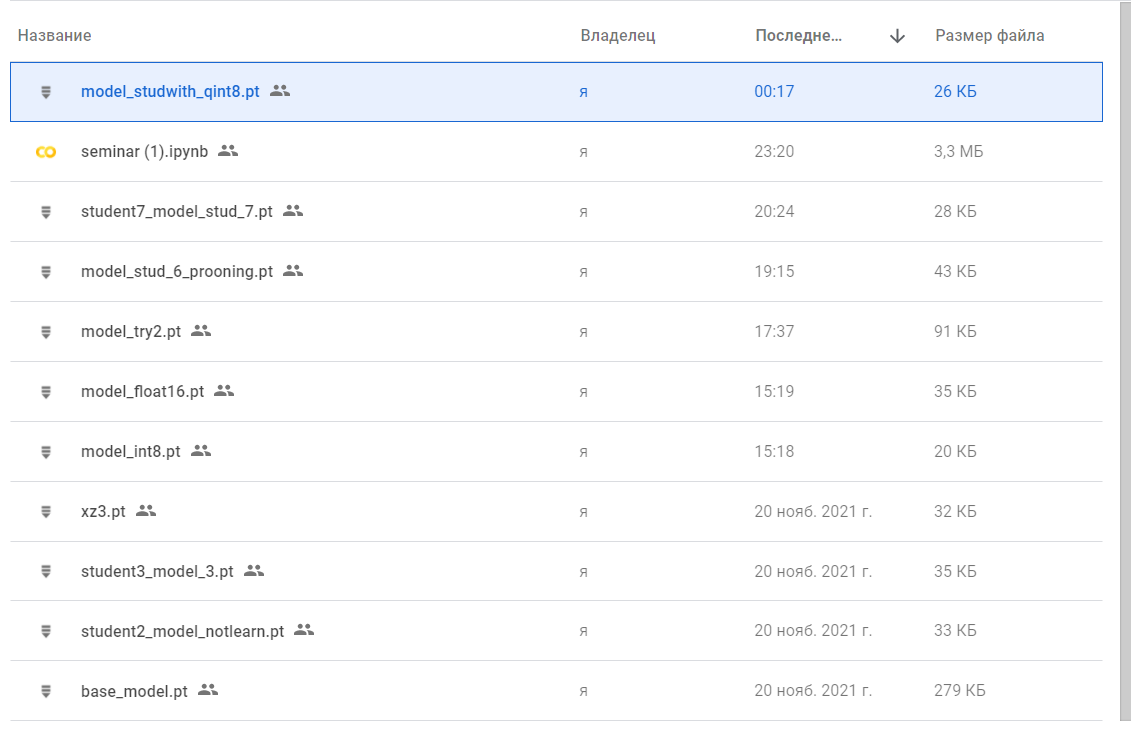

В результате данной работы получилось сжать и ускорить base_model в 10.73 раз и 8.62 раза соответсвенно при использовании сильной дистиляции и квантизации до qint8

Самый крутой результат дал прием дистиляции, благодаря которому была получена наилучшее сжатие. Прием квантизации до qint8 тоже помог сжать модель, а вот pruning не дал резульатов улучшения сжатия (использовал в try 6)

Также был получен интересный результат, что квантование до float16, не сжимает модель, а напротив увеличивает немного в размере 

Так как при квантизации, не работет функции количества параметров, то для сравнивания размера использовалась параметр памяти при сохранении модели, а скорость считалась неизменным, таким же как и у родителя 

В данной работе не получилось реалтзовать инференсную версию, сделал что-то на подобие инференса, но не то что нужно